# <center><B>MSCA-31006 <span style="color:maroon">Time Series Analysis and Forecasting</span></B></center>
## <center><B><U><i>Final Project</i></U></B></center>&nbsp; <center><i>Model Building - Production and Capacity</i></center>

In [6]:
library(stats)
library(tseries)
library(TSA)
library(fpp)
library(fpp2)
library(dlm)
library(vars)
library(ggplot2)
library(forecast)
library(urca)

<br>

<h4>Useful Conversions:</h4>

- $1\,\text{MWh}\: \xrightarrow{\times} \: 3.412\times10^{-6}\: \xrightarrow{=}\: 1\,\text{Trillion Btu}$

- $1\,\text{Trillion Btu}\: \xrightarrow{\div} \: 3.412\times10^{-6}\: \xrightarrow{=}\:1\,\text{MWh}$

- $1\,\text{million KWh}\: \xrightarrow{\times} \: 3.412\times10^{-3}\: \xrightarrow{=}\: 1\,\text{Trillion Btu}$

- $1\,\text{Trillion Btu}\: \xrightarrow{\div} \: 3.412\times10^{-3}\: \xrightarrow{=}\: 1\,\text{million KWh}$

- $1\,\text{MWh}\: \xrightarrow{\div} \: (24\times 30)\: \xrightarrow{=}\:1\,\text{MW}$ for <i>monthly</i> data

In [7]:
# Use these variables for easy conversion
btu2MW <- 3.412e-6
btu2kW <- 3.412e-3
MWh2MW <- (24*30)

<br>

<h4><b>Load <i>all</i> the data</b></h4>
Even if not all of it is used for modeling, some of it may be important for reference and analysis.

In [8]:
dta <- load("Monthly_Data.RData")
ts <- load("Time_Series.RData")
ILdta <- load("IL_Data.RData")
cap <- load("capacity.RData")

In [9]:
print(c(dta, ts, ILdta, cap))

 [1] "monthly_dta"    "monthly_meta"   "monthly_dta_ts" "yearly_dta_ts" 
 [5] "IL_data"        "IL_solar"       "IL_wind"        "IL_wind_ts"    
 [9] "IL_solar_ts"    "capacity"       "wind_cap"       "wind_cap_ts"   
[13] "solar_cap"      "solar_cap_ts"   "ng_cap"         "ng_cap_ts"     
[17] "coal_cap"       "coal_cap_ts"   


<br>

---

<br>

<h4><u><b>Electricity Generation from Wind and Solar</b></u></h4>

The primary target is to forecast the <b><i>proportion</i></b> of electricity from wind and solar energy in the coming years. For this analysis, wind and solar electricity production are combined to represent the "newest" type of renewable energy. Much of the recent investment and development has focused on these two sources because of their flexibility, very low environmental impact, and rapidly decreasing levelized costs (the cost of producing 1MWh of electricity when capital and operating costs are factored in) which has fallen in line with or below traditional sources of electricity. For convenience, we will refer to the <u>combination of wind and solar</u> as <i>"renewables"</i> and their data with the suffix/prefix `rnw`.


In [10]:
tot <- monthly_dta_ts$Elec_by_Source[,"V14"]  # total electrical generation from all sources
rnw_gen <- monthly_dta_ts$Elec_by_Source[,"V13"] + monthly_dta_ts$Elec_by_Source[,"V12"]  # electric output from renewables
rnw_prct <- (rnw_gen/tot)*100  # renewables as percent of total

<br>

<h4><b>Time Series Breakdown</b></h4>

Plotting production in trillions of Btu and production as a proportion of overall electical generation:

In [11]:
options(repr.plot.width = 10, repr.plot.height = 7)

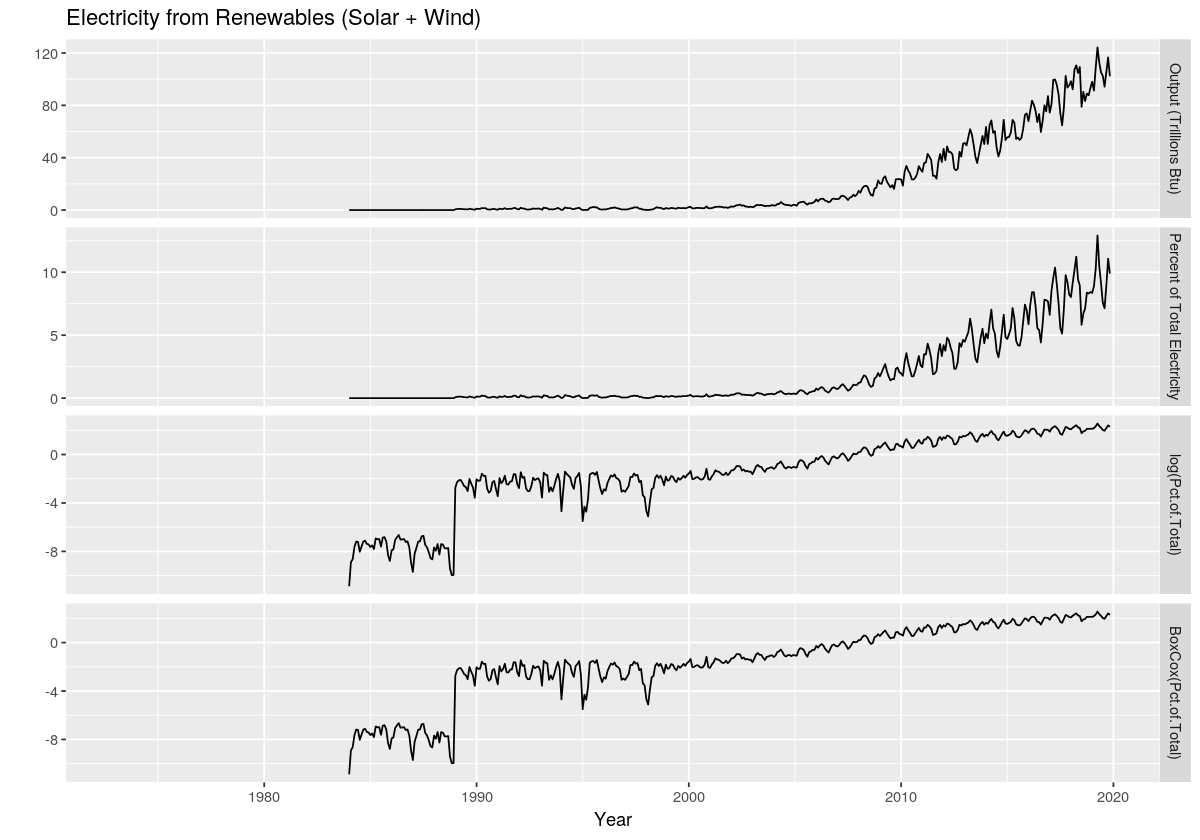

In [12]:
dta <- cbind("Output (Trillions Btu)" = rnw_gen, "Percent of Total Electricity" = rnw_prct, 
             "log(Pct.of.Total)" = log(rnw_prct), "BoxCox(Pct.of.Total)" = log(rnw_prct))

autoplot(dta, facets = T) + xlab("Year") + ylab("") + 
    ggtitle("Electricity from Renewables (Solar + Wind)")

It is clear that this series is non-stationary in both mean and variance with obvious seasonlality. The seasonality is clearly <i>multiplicative</i>. Taking the $\log$ or a BoxCox transformation can potentially stabilize the data but only for the portion from about year 2000 onwards when renewables truly start to take off as a source of energy. The output values for wind and solar are so small before that they are practically negligible by comparison to later values. Wind production only starts to be meaningful around 1998 and solar starts to have an impact after 2005. For this reason, a subset of this time-series beginning in 2000 will be used instead.

In [13]:
# overwrite time-series with new ts starting in 2000
rnw_gen <- window(rnw_gen, start = c(1999,12))  # electric output from renewables
rnw_prct <- (rnw_gen/tot)*100  # renewables as percent of total

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6)

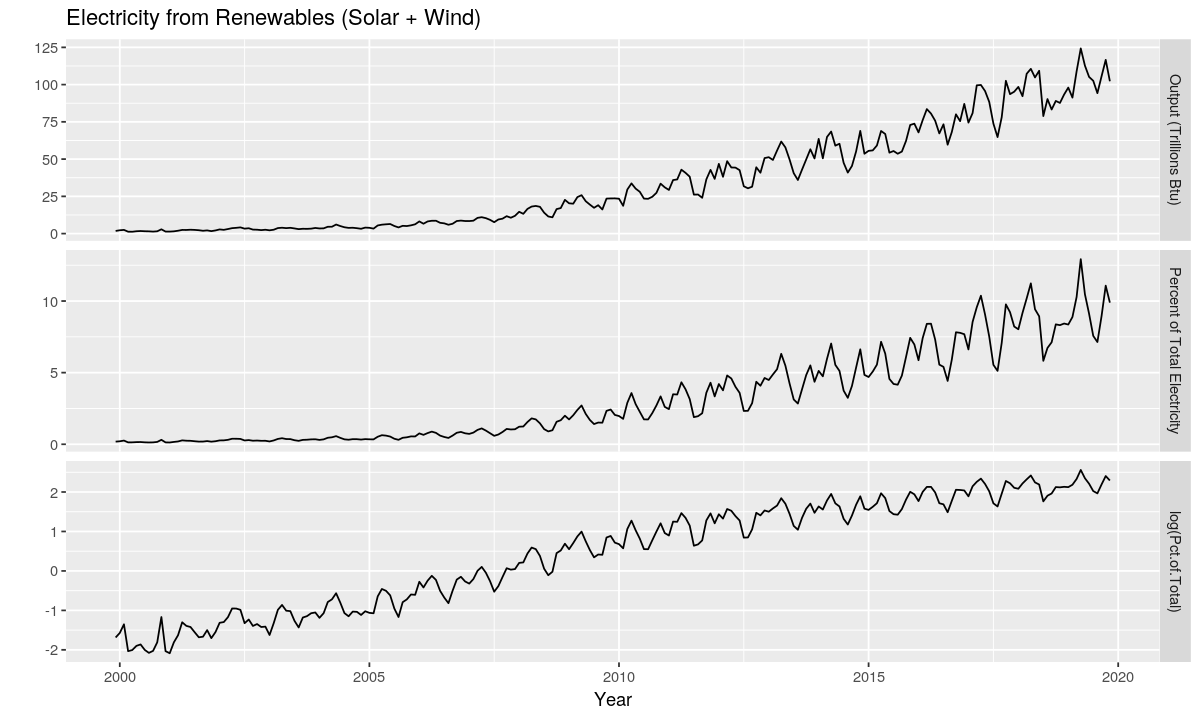

In [15]:
dta <- cbind("Output (Trillions Btu)" = rnw_gen, "Percent of Total Electricity" = rnw_prct, 
             "log(Pct.of.Total)" = log(rnw_prct))

autoplot(dta, facets = T) + xlab("Year") + ylab("") + 
    ggtitle("Electricity from Renewables (Solar + Wind)")

<br>

<u>Stationarity, Seasonality and Trends:</u>

In [433]:
options(repr.plot.width = 10, repr.plot.height = 6)

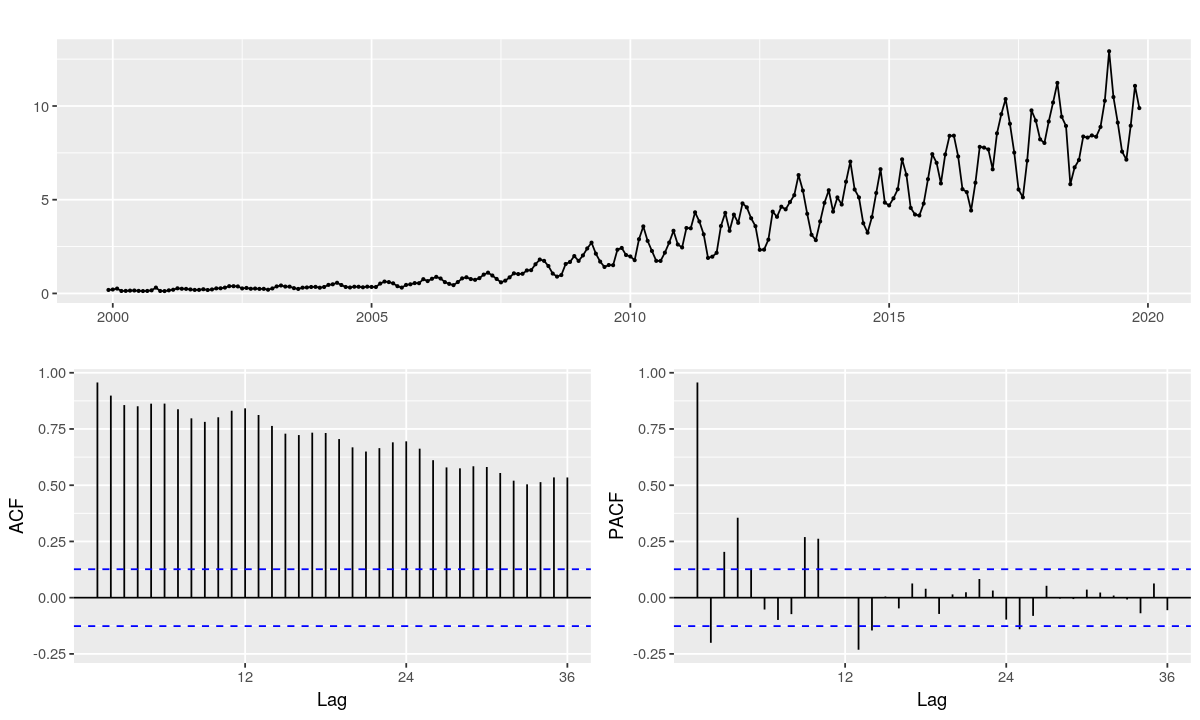

In [17]:
ggtsdisplay(rnw_prct, na.rm = T)

The ACF plot shows that the data is non-stationary and this is confirmed by the KPSS test.

In [18]:
kpss.test(rnw_prct)

Warning message in kpss.test(rnw_prct):
“p-value smaller than printed p-value”


	KPSS Test for Level Stationarity

data:  rnw_prct
KPSS Level = 4.4776, Truncation lag parameter = 4, p-value = 0.01


STL Decomposition of the time-series follows. STL is chosen because it is robust to outliers and some of the unusual data points in this set (especially the earlier part of the series where values are still quite small and "spiky), and it also handles the unusual seasonal pattern. Since STL only accepts additive seasonality, the function `mstl` is used with a Box-Cox transformation for the decomposition.

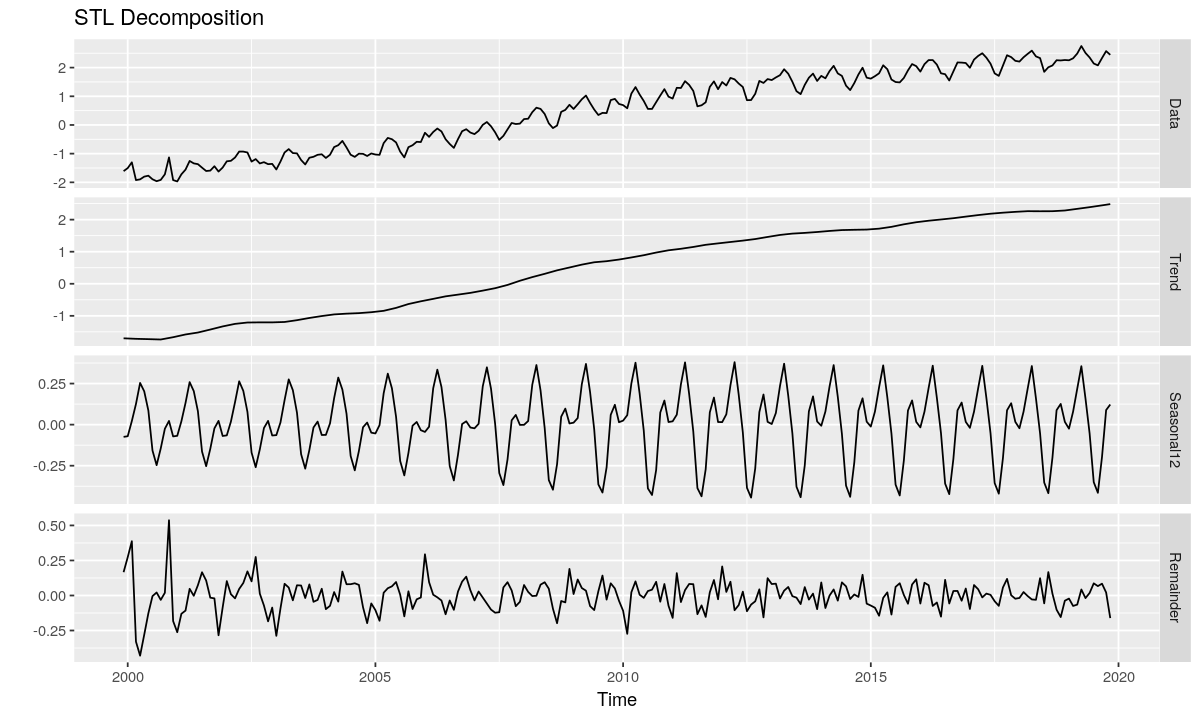

In [19]:
fit <- mstl(rnw_prct, lambda = 'auto')
autoplot(fit) + ggtitle("STL Decomposition")

The decomposition captures the changing seasonal pattern while the effect of the small early patterns appears in the remainder.

<br>

Examining the effect of first-order seasonal and non-seasonal differencing

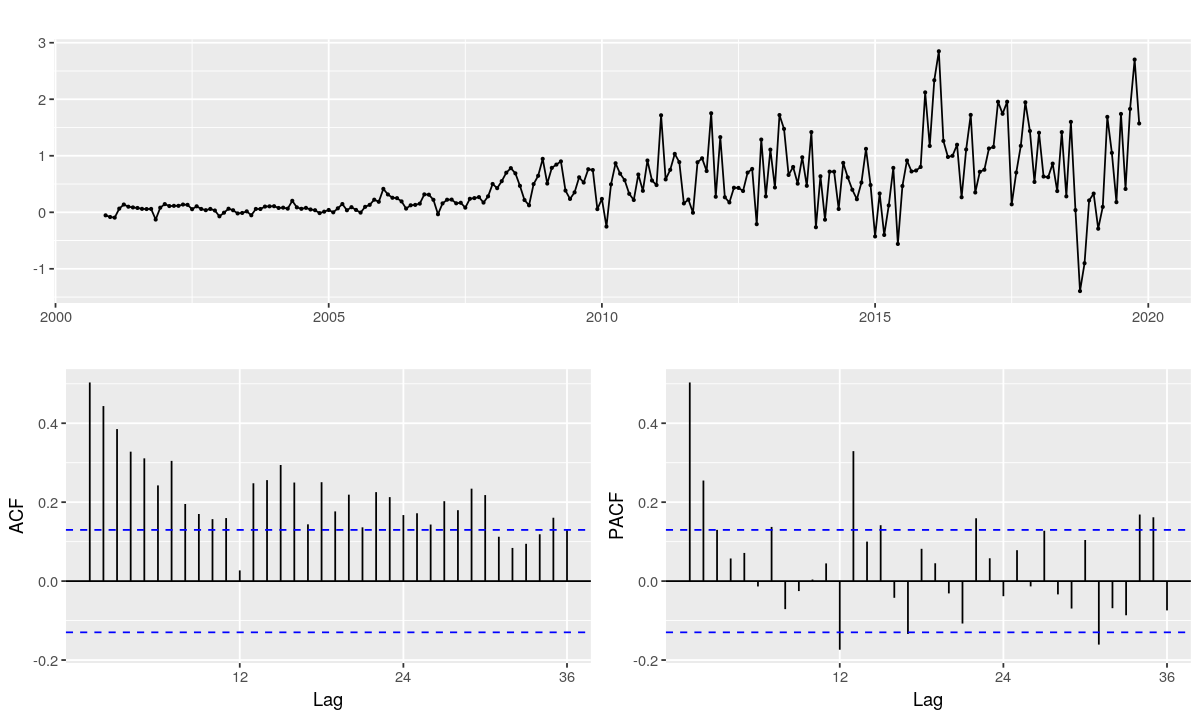

In [434]:
rnw_prct %>% diff(lag = 12) %>% ggtsdisplay()

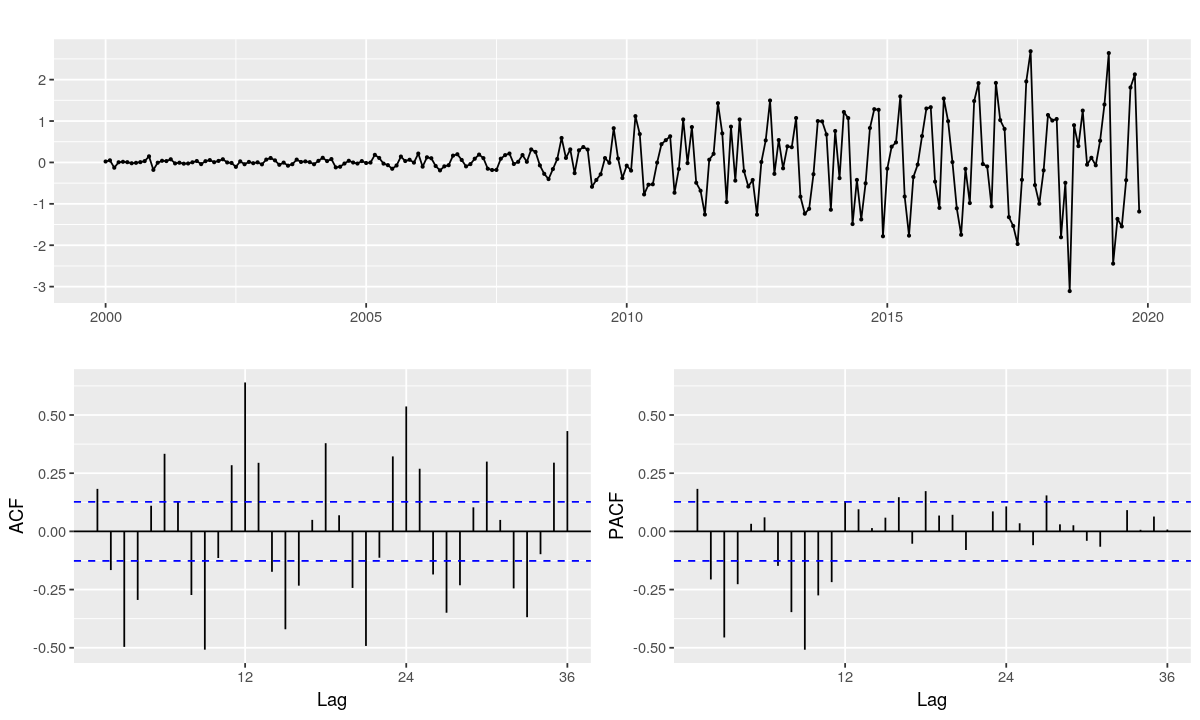

In [435]:
rnw_prct %>% diff(lag = 1) %>% ggtsdisplay()

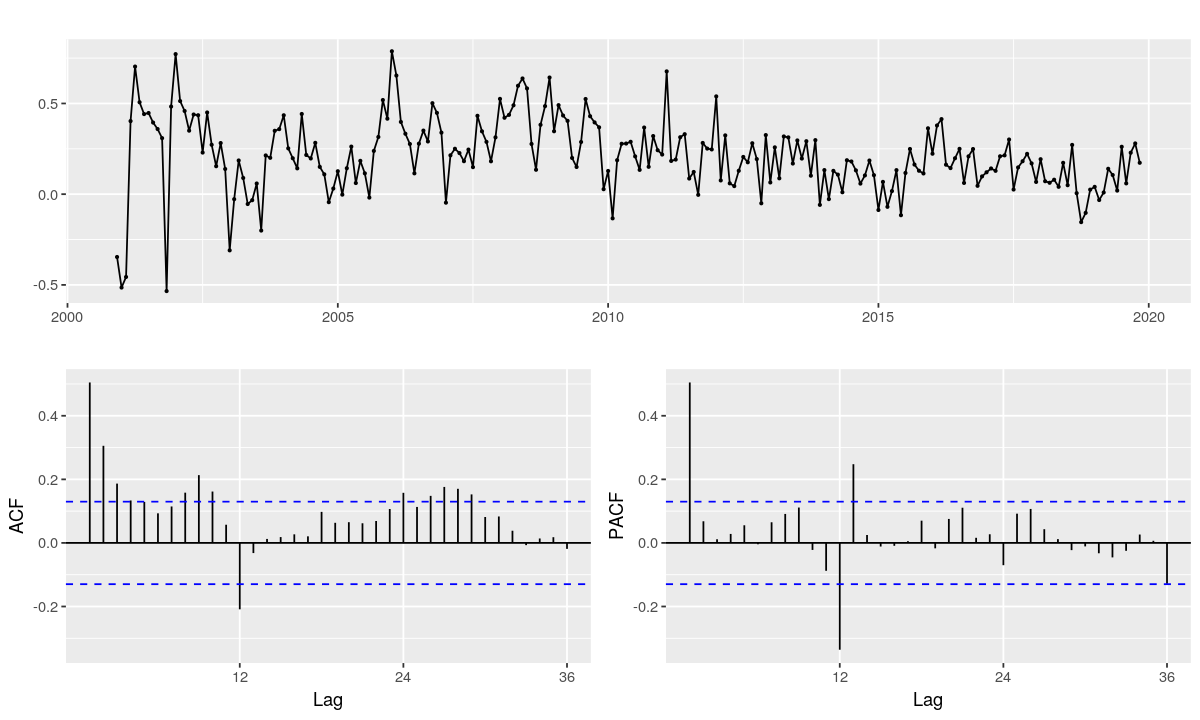

In [436]:
log(rnw_prct) %>% diff(lag = 12) %>% ggtsdisplay()

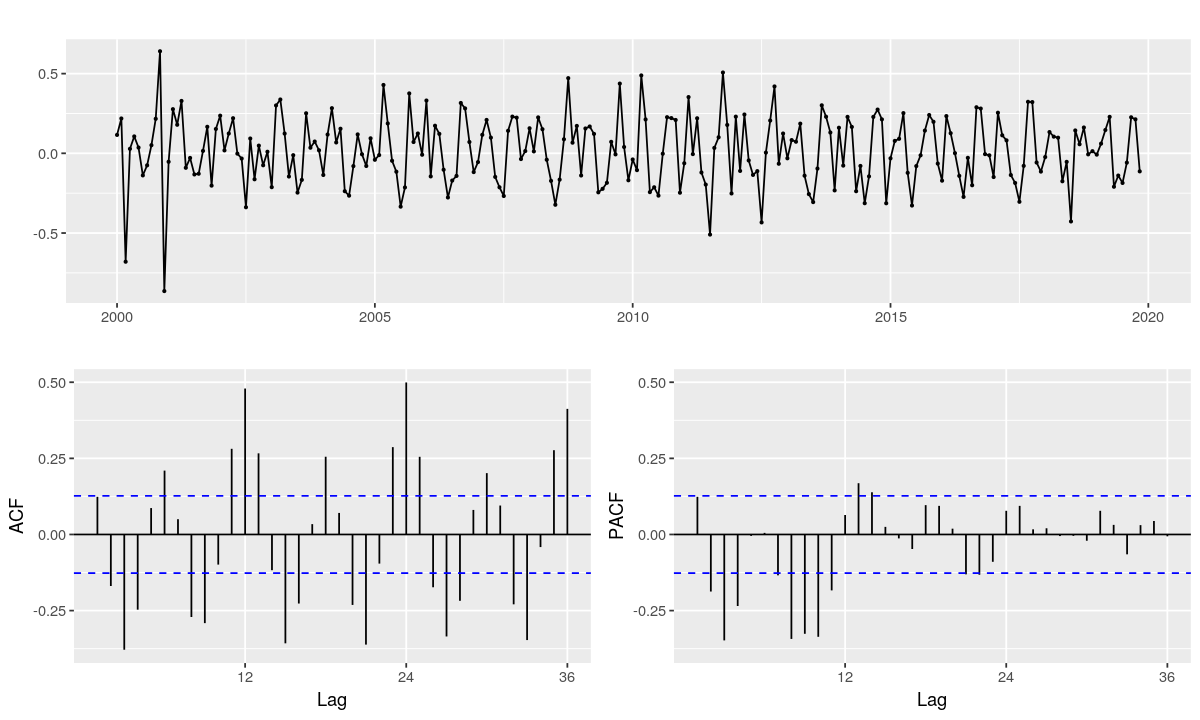

In [437]:
log(rnw_prct) %>% diff(lag = 1) %>% ggtsdisplay()

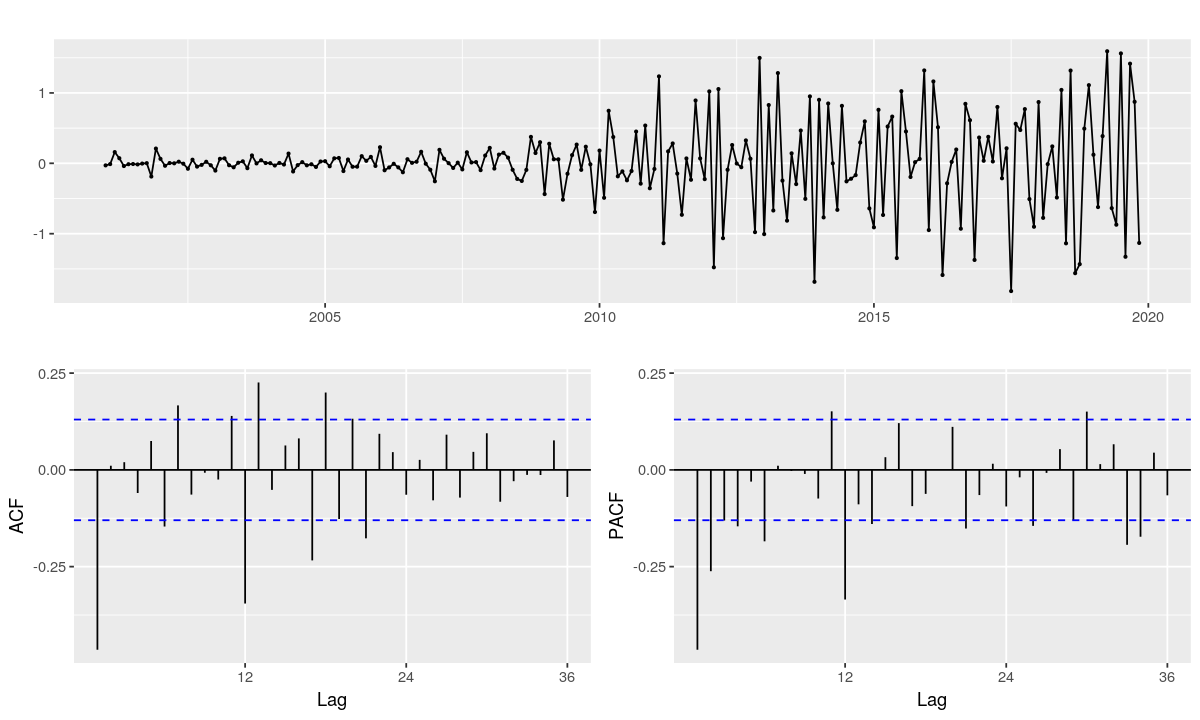

In [438]:
rnw_prct %>% diff(lag = 12) %>% diff(lag = 1) %>% ggtsdisplay()

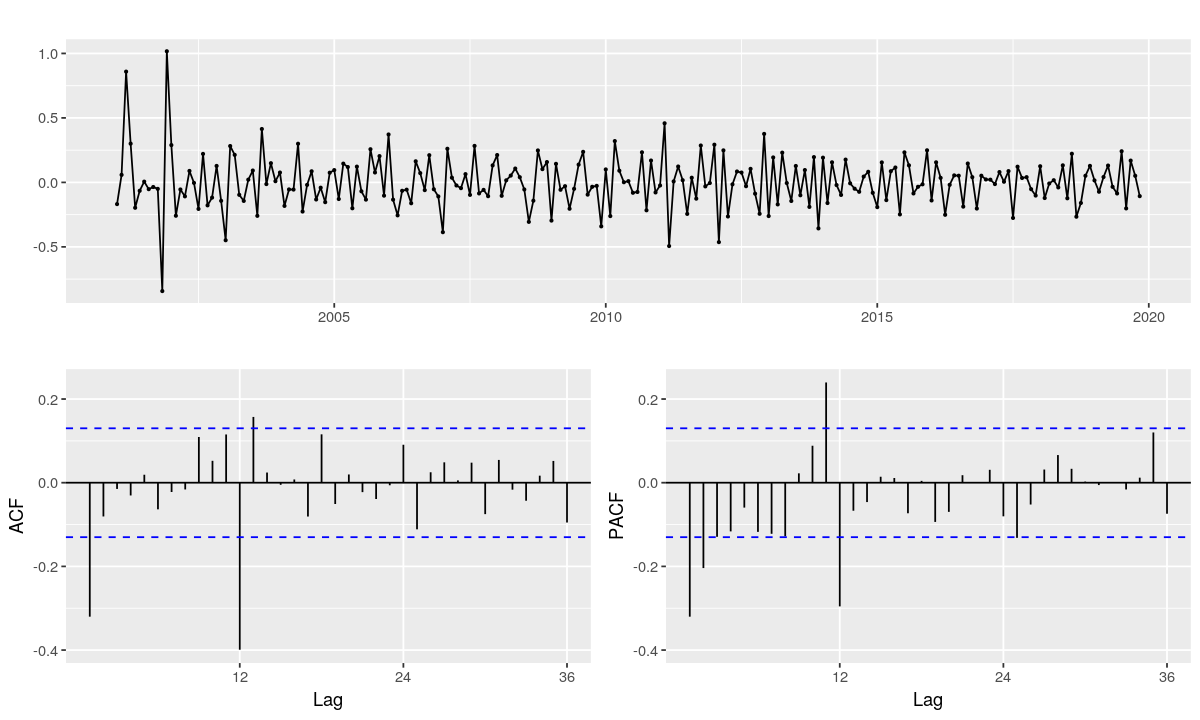

In [440]:
log(rnw_prct) %>% diff(lag = 12) %>% diff(lag = 1) %>% ggtsdisplay()

<br>

<br>

<h3><b><u>Models - Univariate</u></b></h3>

To model electricity generation from renewables (meaning solar and wind as described earlier) as a percentage of electricity overall electric production, several models were chosen that can be divided into two sets. The first set are models that use only the information from this dataset itself. For this set, three types of models are used. An <b>ETS</b> model, an <b>ARIMA</b> model, and a <b>dynamic harmonic regression</b> model. The second set includes additional terms from other data sets (see the EDA portion of this study) to improve the model. For this set, <b>regression with ARIMA errors</b> and <b>VAR</b> models are applied.

<br>

<u>Training Set</u>: A subset of the data is firstcompare models within a family using cross-validation. The same process is then used on the whole data set to compare the best models from each family using the entire time-series to select the best overall model for forecasting. The subset chosen is a period of 8 years between 2004 and 2012 that captures the pattern in the series by including both the low-growth early stage and the higher growth period.

In [20]:
rnw_tr <- window(rnw_prct, start = c(2004, 1), end = c(2011, 12))

The following function is used to create sliding and expanding windows for cross-validation and comparison. It will be used throughout the modeling process.

In [21]:
wins <- function(ts, k, n, p, H) {

    # ts = time series for cv
    # k = Min data length for fitting a model
    # n = Number of data points
    # p = Period
    # H = Forecast Horizon

    tr_exp <- vector("list", n-k)  # Expanding training set
    tr_roll <- vector("list", n-k)  # Rolling training set
    testSet <- vector("list", n-k)  # Test set

    start <- tsp(ts)[1]
    end <- tsp(ts)[1] + (k-2)/p
    step <- 1/p

    suppressWarnings(
        for (i in 1:(n-k)) {
        # Set up model windows
        tr_exp[[i]] <- window(ts, end = end + i*step)
        tr_roll[[i]] <- window(ts, start = start + (i-1)*step, end = end + i*step)
        testSet[[i]] <- window(ts, start = end + (i+1)*step, end = end + (i+H)*step)
    } )
    
    return(list("tr_exp" = tr_exp, "tr_roll" = tr_roll, "testSet" = testSet))
}

In [92]:
# set the variables for the subset models
k <- 60
n <- length(rnw_tr)
p <- 12
H <- 12
# create models for first cross-validation
rnw_tests <- wins(rnw_tr, k = k, n = n, p = p, H = H)

<br>

<h4><u>ETS Model</u></h4>

In [23]:
Model_1a <- ets(rnw_prct, model = 'ZZZ', lambda = 'auto')
summary(Model_1a)

ETS(A,A,A) 

Call:
 ets(y = rnw_prct, model = "ZZZ", lambda = "auto") 

  Box-Cox transformation: lambda= 0.0561 

  Smoothing parameters:
    alpha = 0.2923 
    beta  = 1e-04 
    gamma = 1e-04 

  Initial states:
    l = -1.727 
    b = 0.0192 
    s = 0.0973 0.0459 -0.205 -0.343 -0.2885 -0.0077
           0.1786 0.322 0.1984 0.0503 -0.0271 -0.0212

  sigma:  0.1491

     AIC     AICc      BIC 
419.2305 421.9872 478.4013 

Training set error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set -0.03139889 0.3879137 0.2496587 -1.723782 11.24095 0.4672053
                  ACF1
Training set 0.1148523


In [169]:
Model_1b <- ets(rnw_prct, model = 'ZZZ', lambda = NULL)
summary(Model_1b)

ETS(M,A,M) 

Call:
 ets(y = rnw_prct, model = "ZZZ", lambda = NULL) 

  Smoothing parameters:
    alpha = 0.436 
    beta  = 0.0056 
    gamma = 0.0958 

  Initial states:
    l = 0.187 
    b = 0.0078 
    s = 1.162 0.9797 0.808 0.6934 0.742 1.0167
           1.137 1.3475 1.2284 1.0174 0.9529 0.9151

  sigma:  0.1471

     AIC     AICc      BIC 
629.0215 631.7782 688.1923 

Training set error measures:
                    ME      RMSE       MAE        MPE     MAPE      MASE
Training set 0.0307129 0.4010302 0.2536912 -0.9944185 10.96984 0.4747517
                    ACF1
Training set -0.05629296


In [25]:
Model_1c <- ets(rnw_prct, model = 'ZZZ', lambda = 0)
summary(Model_1c)

ETS(A,A,A) 

Call:
 ets(y = rnw_prct, model = "ZZZ", lambda = 0) 

  Box-Cox transformation: lambda= 0 

  Smoothing parameters:
    alpha = 0.4561 
    beta  = 1e-04 
    gamma = 1e-04 

  Initial states:
    l = -1.6966 
    b = 0.0168 
    s = 0.0674 0.0162 -0.2089 -0.3308 -0.2628 0.0158
           0.1975 0.3231 0.2011 0.0551 -0.0415 -0.0323

  sigma:  0.147

     AIC     AICc      BIC 
412.5824 415.3392 471.7533 

Training set error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set -0.02403028 0.4081348 0.2622405 -1.082176 10.66901 0.4907506
                  ACF1
Training set 0.0662027


<br>

Models 1a and 1c are directly comparable because they both use a BoxCox transformation of the data (model 1c is just the log transformation) and build completely additive models. From the AICc and BIC values, model 1c should be slightly better even though 1a fits the given data more closely with lower RMSE and MAE values. Model 1b is a multiplicative Holt-Winters with no transformation so the AICc and BIC values are not directly comparable to the other two models. Using the sliding vs expanding window approach, test all three models:

In [26]:
# create test models
m1a <- function(x, h) {forecast(ets(x, model = 'AAA', lambda = 'auto'), h = h)}
m1b <- function(x, h) {forecast(ets(x, model = 'MAM', lambda = NULL), h = h)}
m1c <- function(x, h) {forecast(ets(x, model = 'AAA', lambda = 0), h = h)}

In [27]:
# test each model on the expanding and rolling training set
m1a_exp <- lapply(rnw_tests$tr_exp, function(x) m1a(x, h=H))
m1a_roll <- lapply(rnw_tests$tr_roll, function(x) m1a(x, h=H))
m1b_exp <- lapply(rnw_tests$tr_exp, function(x) m1b(x, h=H))
m1b_roll <- lapply(rnw_tests$tr_roll, function(x) m1b(x, h=H))
m1c_exp <- lapply(rnw_tests$tr_exp, function(x) m1c(x, h=H))
m1c_roll <- lapply(rnw_tests$tr_roll, function(x) m1c(x, h=H))

In [158]:
aicc <- c()
rmse <- c()
mae <- c()
i <- 1

for (mdl in list(m1a_exp, m1a_roll, m1b_exp, m1b_roll, m1c_exp, m1c_roll)) {
    aicc[i] <- mean(sapply(mdl, function(x) x$model$aicc))
    rmse[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_tests$testSet[[j]])[2,"RMSE"]))
    mae[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_tests$testSet[[j]])[2,"MAE"]))
    i <- i+1
}

results <- data.frame(Model = as.character(substitute(c(m1a_exp, m1a_roll, m1b_exp, m1b_roll, m1c_exp, m1c_roll)))[-1], 
                      AICc = aicc,  RMSE = rmse,  MAE = mae)
results

Model,AICc,RMSE,MAE
<fct>,<dbl>,<dbl>,<dbl>
m1a_exp,52.85308,0.3870830,0.3216225
m1a_roll,19.40040,0.3985039,0.3373226
m1b_exp,37.84497,0.4078757,0.3272288
m1b_roll,34.81517,0.3649608,0.2991727
m1c_exp,50.93307,0.3748936,0.3105646
m1c_roll,21.91733,0.3695327,0.3088270


Of these models, the additive ETS model with $\lambda=0\:$ (i.e. log of the percent of production) performed best on the subset. It also had the better AICc/BIC values of the two Box-Cox models on the full dataset, so this is the ETS model that will be used for the rest of the analysis.

<br>

<h4><u>Seasonal ARIMA</u></h4>

In [444]:
options(repr.plot.width = 8, repr.plot.height = 4)

In [415]:
Model_2a <- auto.arima(rnw_prct, seasonal = T, lambda = "auto", stepwise = F)
summary(Model_2a)

Series: rnw_prct 
ARIMA(2,1,1)(1,1,1)[12] 
Box Cox transformation: lambda= 0.05612143 

Coefficients:
         ar1     ar2      ma1     sar1     sma1
      0.4031  0.0289  -0.8810  -0.0087  -0.7406
s.e.  0.0785  0.0751   0.0395   0.1527   0.1407

sigma^2 estimated as 0.02089:  log likelihood=114.13
AIC=-216.25   AICc=-215.87   BIC=-195.7

Training set error measures:
                      ME      RMSE      MAE        MPE    MAPE      MASE
Training set -0.04491076 0.4156094 0.263827 -0.4864053 10.1122 0.4937196
                   ACF1
Training set -0.1556908



	Ljung-Box test

data:  Residuals from ARIMA(2,1,1)(1,1,1)[12]
Q* = 30.792, df = 19, p-value = 0.04254

Model df: 5.   Total lags used: 24



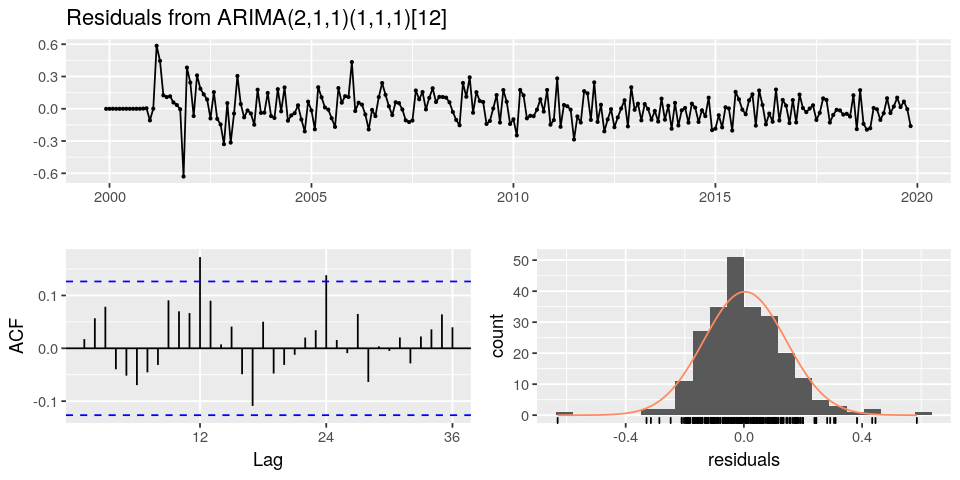

In [445]:
checkresiduals(Model_2a)

In [30]:
Model_2b <- auto.arima(rnw_prct, seasonal = T, lambda = NULL, stepwise = F)
summary(Model_2b)

Series: rnw_prct 
ARIMA(1,1,2)(0,1,1)[12] 

Coefficients:
         ar1      ma1     ma2     sma1
      0.6764  -1.3093  0.3550  -0.4394
s.e.  0.1616   0.1891  0.1636   0.0618

sigma^2 estimated as 0.1965:  log likelihood=-137.4
AIC=284.79   AICc=285.07   BIC=301.92

Training set error measures:
                     ME      RMSE       MAE      MPE     MAPE      MASE
Training set 0.04624498 0.4273024 0.2829539 1.384332 10.93428 0.5295132
                    ACF1
Training set -0.02128107



	Ljung-Box test

data:  Residuals from ARIMA(1,1,2)(0,1,1)[12]
Q* = 52.659, df = 20, p-value = 9.12e-05

Model df: 4.   Total lags used: 24



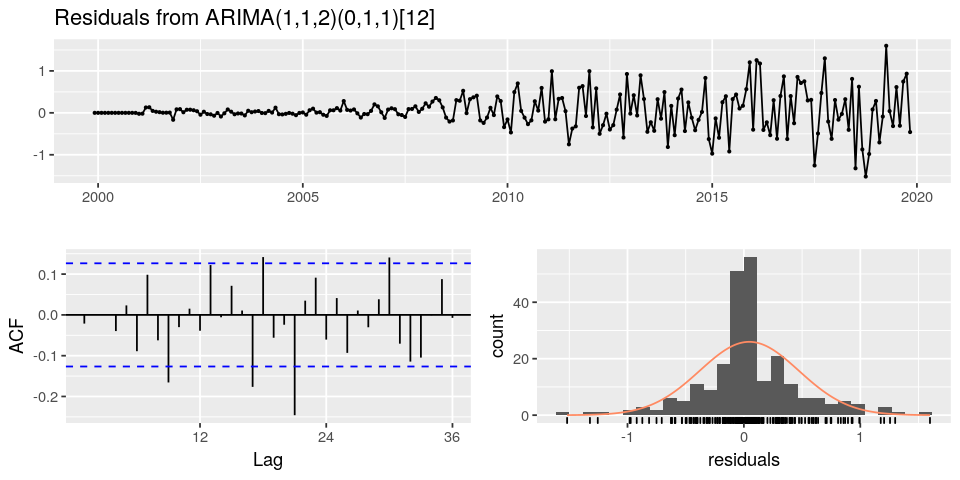

In [446]:
checkresiduals(Model_2b)

In [31]:
Model_2c <- auto.arima(rnw_prct, seasonal = T, lambda = 0, stepwise = F)
summary(Model_2c)

Series: rnw_prct 
ARIMA(2,1,2)(0,1,1)[12] 
Box Cox transformation: lambda= 0 

Coefficients:
         ar1      ar2      ma1     ma2     sma1
      1.4606  -0.4941  -1.9023  0.9149  -0.8604
s.e.  0.0857   0.0754   0.0540  0.0489   0.0796

sigma^2 estimated as 0.02053:  log likelihood=113.17
AIC=-214.34   AICc=-213.96   BIC=-193.79

Training set error measures:
                      ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.05274286 0.4185222 0.2682729 -0.9011298 10.18663 0.5020395
                   ACF1
Training set -0.1166099



	Ljung-Box test

data:  Residuals from ARIMA(2,1,2)(0,1,1)[12]
Q* = 41.195, df = 19, p-value = 0.002273

Model df: 5.   Total lags used: 24



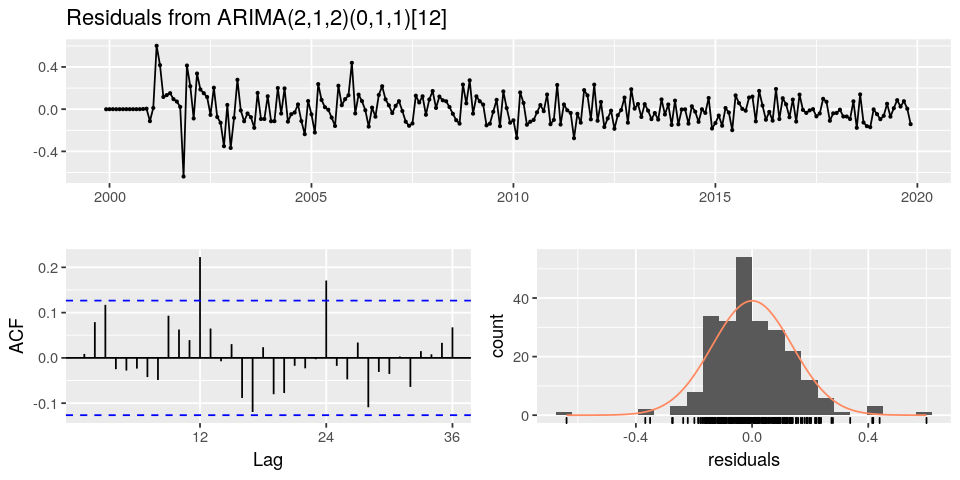

In [447]:
checkresiduals(Model_2c)

<br>

Models 2a and 2c both use the BoxCox transformation and have the same orders of seasonal and nonseasonal differences, so AICc/BIC values should be comparable. Model 1a is clearly the better of the two as it has lower values of both and also fits the data slightly better. For further analysis, only 1a and 1b will be cross-validated on the training subset.

In [164]:
# create test models
m2a <- function(x, h) {forecast(Arima(x, order = c(2,1,1), seasonal = c(1,1,1), lambda = 'auto'), h = h)}
m2b <- function(x, h) {forecast(Arima(x, order = c(1,1,2), seasonal = c(0,1,1), lambda = NULL), h = h)}

In [165]:
# test each model on the expanding and rolling training set
m2a_exp <- lapply(rnw_tests$tr_exp, function(x) m2a(x, h=H))
m2a_roll <- lapply(rnw_tests$tr_roll, function(x) m2a(x, h=H))
m2b_exp <- lapply(rnw_tests$tr_exp, function(x) m2b(x, h=H))
m2b_roll <- lapply(rnw_tests$tr_roll, function(x) m2b(x, h=H))

In [166]:
aicc <- c()
rmse <- c()
mae <- c()
i <- 1

for (mdl in list(m2a_exp, m2a_roll, m2b_exp, m2b_roll)) {
    aicc[i] <- mean(sapply(mdl, function(x) x$model$aicc))
    rmse[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_tests$testSet[[j]])[2,"RMSE"]))
    mae[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_tests$testSet[[j]])[2,"MAE"]))
    i <- i+1
}

results <- data.frame(Model = as.character(substitute(c(m2a_exp, m2a_roll, m2b_exp, m2b_roll)))[-1], 
                      AICc = aicc,  RMSE = rmse,  MAE = mae)
results

Model,AICc,RMSE,MAE
<fct>,<dbl>,<dbl>,<dbl>
m2a_exp,-63.183072,0.4595251,0.3937724
m2a_roll,-46.678632,0.4475450,0.3837037
m2b_exp,-17.326247,0.4047207,0.3305260
m2b_roll,-1.079665,0.4101486,0.3378964


Using RMSE value as the deciding factor, choose $\text{ARIMA}(1,1,2)(0,1,1)_{12}$ without Box-Cox transformation (`lambda = NULL`).

<br>

<h4><u>Dynamic Harmonic Regression</u></h4>

In [35]:
mdl <- list()
K <- c()
mdl_nm <- c()
AICc <- c()
BIC <- c()

# Frequency is 12 so K max = 6
for (i in 1:6) {
    fit <- auto.arima(rnw_prct, xreg = fourier(rnw_prct, K = i), seasonal = F, lambda = 'auto', stepwise = F)
    mdl[[i]] <- fit
    K[i] <- i
    mdl_nm[i] <- paste("ARIMA", "(",toString(fit$arma[c(1,6,2)]),")", sep = "")
    AICc[i] <- fit$aicc
    BIC[i] <- fit$bic
}

res <- data.frame("K" = K, "Model" = mdl_nm, "AICc" = AICc, "BIC" = BIC)
res

K,Model,AICc,BIC
<int>,<fct>,<dbl>,<dbl>
1,"ARIMA(4, 1, 1)",-194.3374,-163.8352
2,"ARIMA(4, 1, 1)",-249.3972,-212.3191
3,"ARIMA(4, 1, 1)",-251.7813,-208.2051
4,"ARIMA(4, 1, 1)",-248.8339,-198.8394
5,"ARIMA(4, 1, 1)",-248.1012,-191.7705
6,"ARIMA(4, 1, 1)",-247.5520,-188.0847


For all models, $\text{ARIMA}(4,1,1)$ is chosen for the error terms. The top two models have either 2 or 3 Fourier terms, depending on whether the criteria is AICc or BIC. Setting `lambda = 0` (i.e. taking $\log(y)$) instead of `lambda = 'auto'` gives similar results. The models to be cross-validated have 2 and 3 Fourier terms with auto-selected Box-Cox transformation and a 2-term model with the Box-Cox coefficient set to zero.


	Ljung-Box test

data:  Residuals from Regression with ARIMA(4,1,1) errors
Q* = 27.812, df = 14, p-value = 0.01507

Model df: 10.   Total lags used: 24



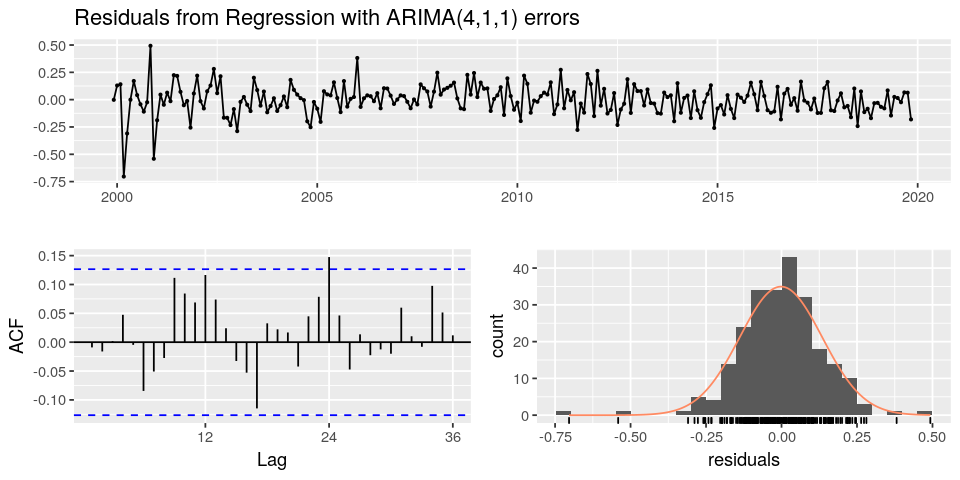

In [449]:
checkresiduals(Arima(rnw_prct, order = c(4,1,1), xreg = fourier(rnw_prct, K=2), include.drift = T, lambda = 'auto'))

In [37]:
# create test models
m3a <- function(x, h) {forecast(Arima(x, order = c(4,1,1), xreg = fourier(x, K=2), include.drift = T, lambda = 'auto'), 
                                xreg = fourier(x, K = 2, h = h))}
m3b <- function(x, h) {forecast(Arima(x, order = c(4,1,1), xreg = fourier(x, K=3), include.drift = T, lambda = 'auto'), 
                                xreg = fourier(x, K = 3, h = h))}
m3c <- function(x, h) {forecast(Arima(x, order = c(4,1,1), xreg = fourier(x, K=2), include.drift = T, lambda = 0), 
                                xreg = fourier(x, K = 2, h = h))}

In [38]:
# test each model on the expanding and rolling training set
m3a_exp <- lapply(rnw_tests$tr_exp, function(x) m3a(x, h=H))
m3a_roll <- lapply(rnw_tests$tr_roll, function(x) m3a(x, h=H))
m3b_exp <- lapply(rnw_tests$tr_exp, function(x) m3b(x, h=H))
m3b_roll <- lapply(rnw_tests$tr_roll, function(x) m3b(x, h=H))
m3c_exp <- lapply(rnw_tests$tr_exp, function(x) m3c(x, h=H))
m3c_roll <- lapply(rnw_tests$tr_roll, function(x) m3c(x, h=H))

In [159]:
aicc <- c()
rmse <- c()
mae <- c()
i <- 1

for (mdl in list(m3a_exp, m3a_roll, m3b_exp, m3b_roll, m3c_exp, m3c_roll)) {
    aicc[i] <- mean(sapply(mdl, function(x) x$model$aicc))
    rmse[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_tests$testSet[[j]])[2,"RMSE"]))
    mae[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_tests$testSet[[j]])[2,"MAE"]))
    i <- i+1
}

results <- data.frame(Model = as.character(substitute(c(m3a_exp, m3a_roll, m3b_exp, m3b_roll, m3c_exp, m3c_roll)))[-1], 
                      AICc = aicc,  RMSE = rmse,  MAE = mae)
results

Model,AICc,RMSE,MAE
<fct>,<dbl>,<dbl>,<dbl>
m3a_exp,-95.49990,0.4352863,0.3739060
m3a_roll,-76.43524,0.4009173,0.3398412
m3b_exp,-91.26746,0.4402242,0.3787850
m3b_roll,-71.48750,0.3921963,0.3327614
m3c_exp,-96.57975,0.3813703,0.3327492
m3c_roll,-74.43177,0.3531882,0.2999606


The dynamic regression model with 2 Fourier terms is selected based on the lower errors and lower AICc when compared to the same model with 3 terms, and the model with Box-Cox $\lambda = 0 \rightarrow\, \log(y)$ is preferred (Model 3c in this case).

<br>

<u>Summary of Selected Models</u>

- $\text{ETS}$ model, log-transformation $\lambda = 0$ with additive error, additive trend, additive seasonality.

- $\text{sARIMA}(1,1,2)(0,1,1)_{12}$ with automatically selected Box-Cox transformation parameter ($\lambda$).

- Dynamic Harmonic Regression with 2 Fourier terms, $\text{ARIMA}(4,1,1)$ errors, log-transformation $\lambda = 0$.

<h4><u>Cross-Validation - Univariate Models</u></h4>

Apply the same process on the three selected models for the whole dataset. This is the set with combined solar and wind production as a percentage of overall electrical production starting December 1999 through December 2019.

In [174]:
# ETS Model
rnw_ETS <- function(x, h) {forecast(ets(x, model = 'AAA', lambda = 0), h = h)}
# ARIMA Model
rnw_ARIMA <- function(x, h) {forecast(Arima(x, order = c(1,1,2), seasonal = c(0,1,1), lambda = NULL), h = h)}
# Dynamic Harmonic Regression
rnw_DHR <- function(x, h) {forecast(Arima(x, order = c(4,1,1), xreg = fourier(x, K=2), include.drift = T, lambda = 0), 
                                xreg = fourier(x, K = 2, h = h))}

<br>

Define variables and validation windows:

In [175]:
# set the variables for the subset models
k <- 144
n <- length(rnw_prct)
p <- 12
H <- 12
# create models for first cross-validation
rnw_wins <- wins(rnw_prct, k = k, n = n, p = p, H = H)

In [176]:
# test each model on the expanding and rolling training set
rnw_ETS_exp <- lapply(rnw_wins$tr_exp, function(x) rnw_ETS(x, h=H))
rnw_ETS_roll <- lapply(rnw_wins$tr_roll, function(x) rnw_ETS(x, h=H))
rnw_ARIMA_exp <- lapply(rnw_wins$tr_exp, function(x) rnw_ARIMA(x, h=H))
rnw_ARIMA_roll <- lapply(rnw_wins$tr_roll, function(x) rnw_ARIMA(x, h=H))
rnw_DHR_exp <- lapply(rnw_wins$tr_exp, function(x) rnw_DHR(x, h=H))
rnw_DHR_roll <- lapply(rnw_wins$tr_roll, function(x) rnw_DHR(x, h=H))

In [301]:
err <- list()
aicc <- c()
rmse <- c()
mae <- c()
i <- 1

for (mdl in list(rnw_ETS_exp, rnw_ETS_roll, rnw_ARIMA_exp, rnw_ARIMA_roll, rnw_DHR_exp, rnw_DHR_roll)) {
    # absolute errors:
    err[[i]] <- sapply(1:(n-k), function(j) abs(rnw_wins$testSet[[j]] - mdl[[j]]$mean))
    # Overall RMSE of forecasts
    rmse[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_wins$testSet[[j]])[2,"RMSE"]))
    # Overall MAE of forecasts
    mae[i] <- mean(sapply(1:(n-k), function(j) accuracy(mdl[[j]], rnw_wins$testSet[[j]])[2,"MAE"]))
    # Overall AICc (less important)                      
    aicc[i] <- mean(sapply(mdl, function(x) x$model$aicc))
    i <- i+1
}

results <- data.frame(Model = as.character(substitute(c(rnw_ETS_exp, rnw_ETS_roll, rnw_ARIMA_exp, rnw_ARIMA_roll, rnw_DHR_exp, rnw_DHR_roll)))[-1], 
                      AICc = aicc,  RMSE = rmse,  MAE = mae)
results

Model,AICc,RMSE,MAE
<fct>,<dbl>,<dbl>,<dbl>
rnw_ETS_exp,325.4982,0.8386125,0.7154132
rnw_ETS_roll,131.3657,0.8562623,0.7363961
rnw_ARIMA_exp,127.7866,0.7090161,0.5801910
rnw_ARIMA_roll,126.1304,0.7076339,0.5778296
rnw_DHR_exp,-171.4204,1.0002399,0.8603077
rnw_DHR_roll,-193.5835,0.9881109,0.8469297


In [321]:
# RMSE and MAE by forecast horizon for each model
MAE_h <- list()
RMSE_h <- list()

for (i in 1:length(err)) {
    mat <- sapply(1:(n-k), function(j) as.vector(err[[i]][[j]][1:p]))
    MAE_h[[i]] <- rowMeans(mat, na.rm = T)
    RMSE_h[[i]] <- sqrt(rowMeans(mat^2, na.rm = T))
}

In [329]:
df_mae <- data.frame(H = 1:p, ETS_exp = MAE_h[[1]], ETS_roll = MAE_h[[2]], ARIMA_exp = MAE_h[[3]], ARIMA_roll = MAE_h[[4]], DHR_exp = MAE_h[[5]], DHR_roll = MAE_h[[6]])
df_rmse <- data.frame(H = 1:p, ETS_exp = RMSE_h[[1]], ETS_roll = RMSE_h[[2]], ARIMA_exp = RMSE_h[[3]], ARIMA_roll = RMSE_h[[4]], DHR_exp = RMSE_h[[5]], DHR_roll = RMSE_h[[6]])

In [369]:
options(repr.plot.width = 12, repr.plot.height = 6)

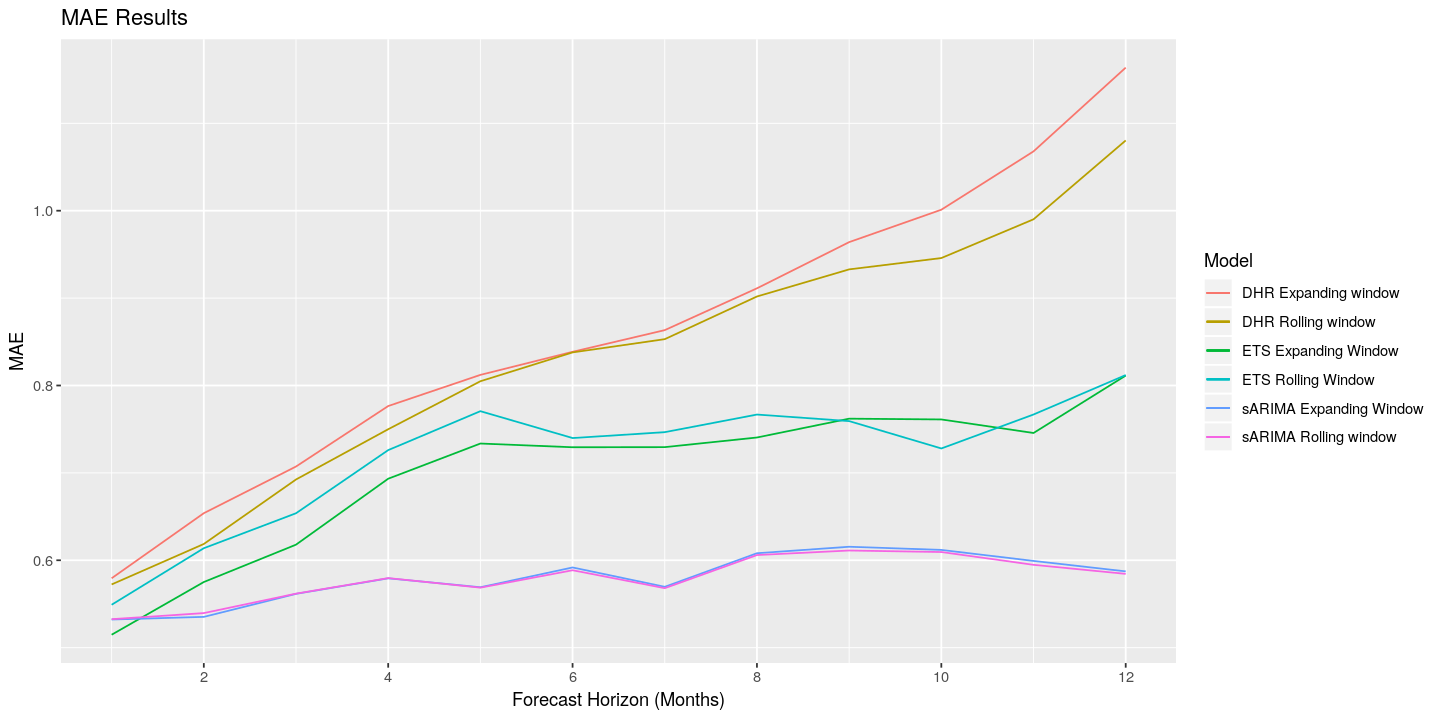

In [391]:
ggplot(data = df_mae, aes(H)) +  
    geom_line(aes(y = ETS_exp, color = "ETS Expanding Window")) +  
    geom_line(aes(y = ETS_roll, color = "ETS Rolling Window")) +  
    geom_line(aes(y = ARIMA_exp, color = "sARIMA Expanding Window")) +  
    geom_line(aes(y = ARIMA_roll, color = "sARIMA Rolling window")) +
    geom_line(aes(y = DHR_exp, color = "DHR Expanding window")) +
    geom_line(aes(y = DHR_roll, color = "DHR Rolling window")) +
    xlab("Forecast Horizon (Months)") + ylab("MAE") + ggtitle("MAE Results") +
    scale_x_continuous(breaks = seq(0,12,2)) + scale_y_continuous(breaks = seq(0,1.2,0.2)) +
    guides(color = guide_legend(title = "Model"))

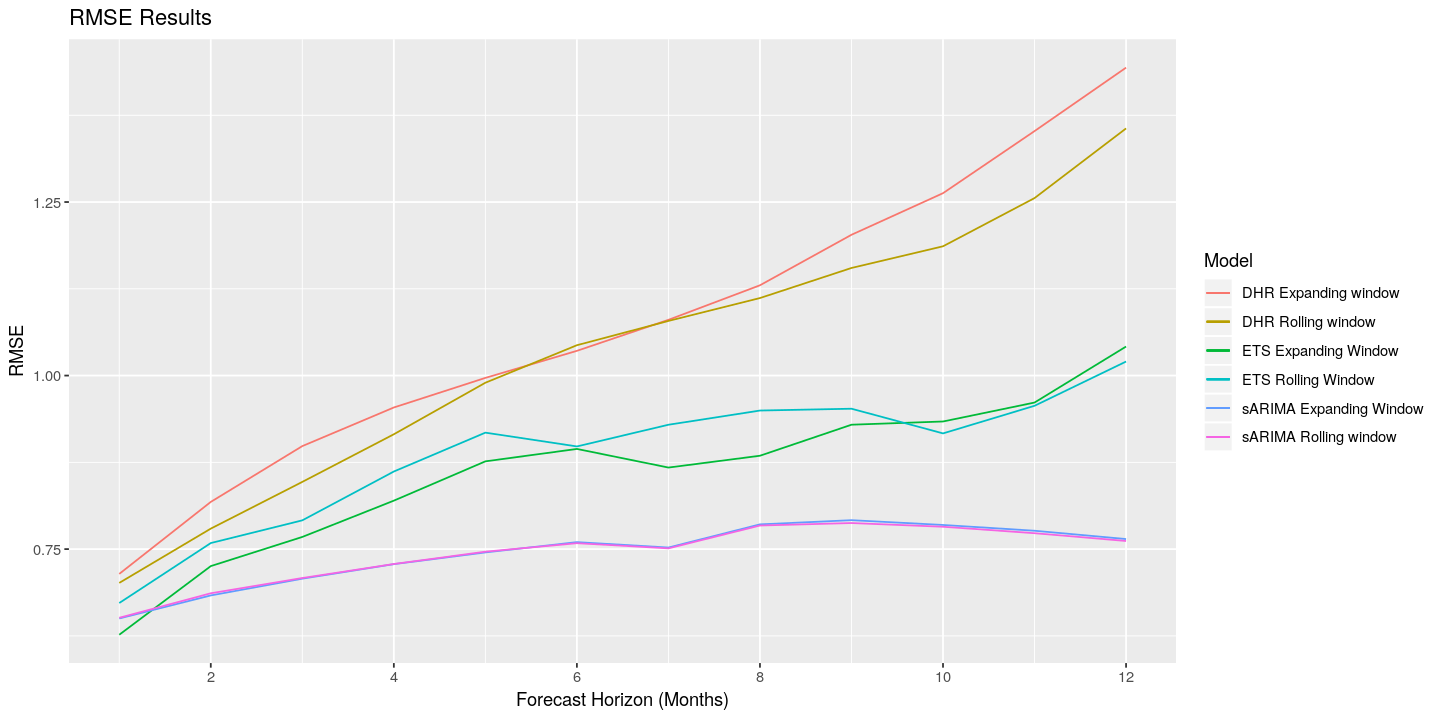

In [392]:
ggplot(data = df_rmse, aes(H)) +  
    geom_line(aes(y = ETS_exp, color = "ETS Expanding Window")) +  
    geom_line(aes(y = ETS_roll, color = "ETS Rolling Window")) +  
    geom_line(aes(y = ARIMA_exp, color = "sARIMA Expanding Window")) +  
    geom_line(aes(y = ARIMA_roll, color = "sARIMA Rolling window")) +
    geom_line(aes(y = DHR_exp, color = "DHR Expanding window")) +
    geom_line(aes(y = DHR_roll, color = "DHR Rolling window")) +
    xlab("Forecast Horizon (Months)") + ylab("RMSE") + ggtitle("RMSE Results") +
    scale_x_continuous(breaks = seq(0,12,2)) + scale_y_continuous(breaks = seq(0,1.5,0.25)) +
    guides(color = guide_legend(title = "Model"))

<br>

The results in the table and plots above for cross-validation make it very clear that the $\text{sARIMA}(1,1,2)(0,1,1)_{12}$ is the most promising model of the three. It has lowest overall model error and unlike the other two models, the errors remain well controlled as the forecast horizon expands. It is also far less sensitive to the window type with very close errors for both expanding and sliding windows.

<br>

<h3><b>Forecasting - Univariate</b></h3>
<h4><i><b>Model</b>: Seasonal $\text{ARIMA}(1,1,2)(0,1,1)_{12}$</i></h4>

<br>

Recalling the time-series:

In [395]:
head(rnw_prct, 20)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1999,,,,,,,,,,,,0.1850780
2000,0.2077245,0.2584613,0.1309368,0.1346704,0.1497312,0.1552436,0.1351615,0.1253403,0.1318841,0.1637873,0.3107029,0.1309154
2001,0.1241622,0.1637848,0.1959048,0.2721234,0.2484966,0.2414033,0.2114352,,,,,


<br>

<h4><u>1 Year Forecast</u></h4>

In [396]:
renewables_1yr <- rnw_ARIMA(x = rnw_prct, h = 12)

In [452]:
options(repr.plot.width = 10, repr.plot.height = 5)

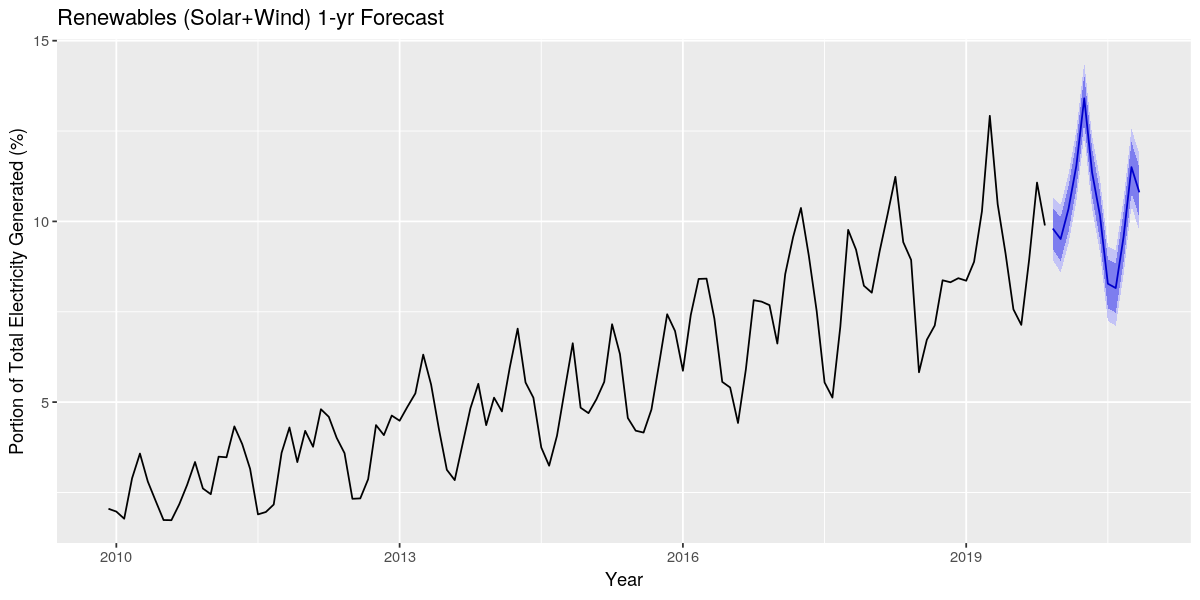

In [455]:
autoplot(renewables_1yr, include = 120) + ggtitle("Renewables (Solar+Wind) 1-yr Forecast") +
    xlab("Year") + ylab("Portion of Total Electricity Generated (%)")

In [537]:
options(repr.plot.width = 10, repr.plot.height = 6)

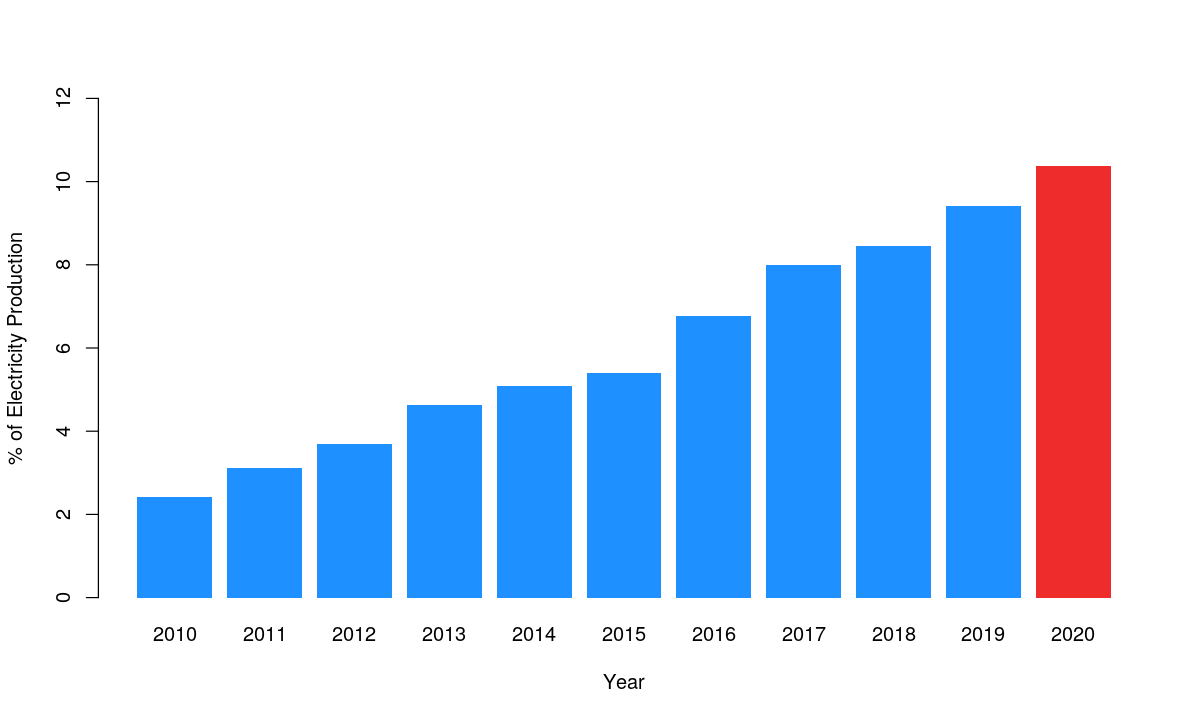

In [650]:
avg <- c()
i <- 1

for (yr in 2009:2018) {
    avg[i] <- mean(window(rnw_prct, start = c(yr, 12), end = c(yr+1, 11)))
    i <- i+1
}

yr_avg <- data.frame(year = seq(2010,2019), avg_pct = avg)
yr_avg <- rbind(yr_avg, c(2020, mean(renewables_1yr$mean)))

# Plot yearly average
cols <- ifelse(yr_avg$year > 2019, "firebrick2", "dodgerblue")
barplot(avg_pct ~ year, yr_avg, 
        xlab = "Year", ylab = "% of Electricity Production", ylim = c(0,12), col = cols, border = NA)

In [651]:
print(t(yr_avg))

               [,1]        [,2]        [,3]        [,4]        [,5]        [,6]
year    2010.000000 2011.000000 2012.000000 2013.000000 2014.000000 2015.000000
avg_pct    2.419215    3.104869    3.690491    4.618677    5.077554    5.408938
               [,7]        [,8]        [,9]      [,10]     [,11]
year    2016.000000 2017.000000 2018.000000 2019.00000 2020.0000
avg_pct    6.772713    8.006802    8.463058    9.42274   10.3697


<br>

<h4><u>2 Year Forecast</u></h4>

In [652]:
renewables_2yr <- rnw_ARIMA(x = rnw_prct, h = 24)

In [653]:
options(repr.plot.width = 10, repr.plot.height = 5)

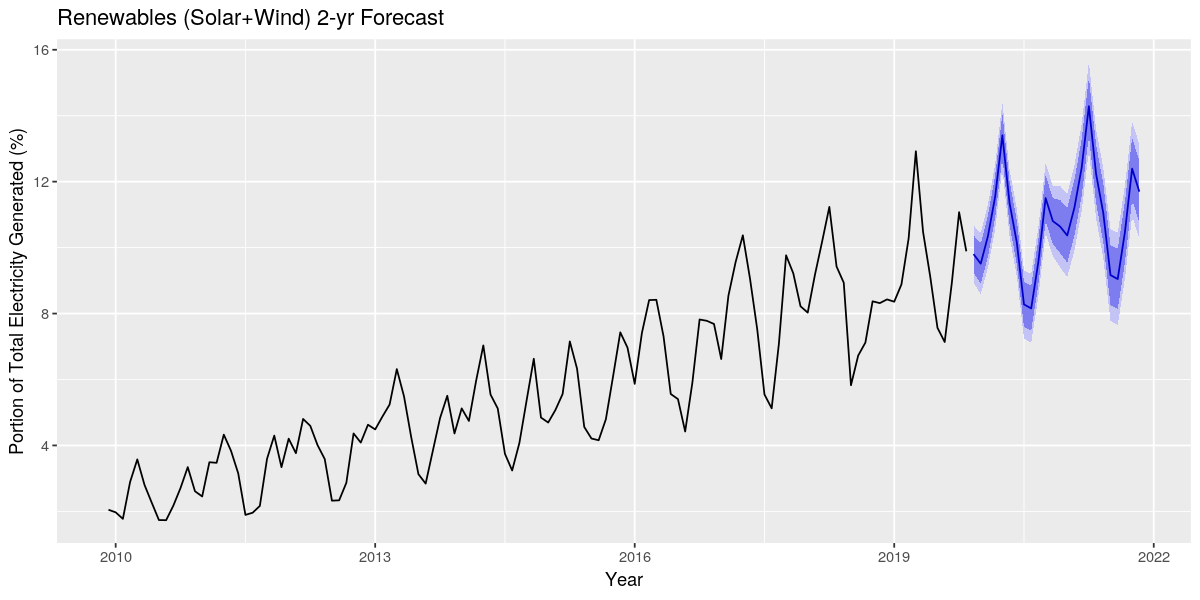

In [654]:
autoplot(renewables_2yr, include = 120) + ggtitle("Renewables (Solar+Wind) 2-yr Forecast") +
    xlab("Year") + ylab("Portion of Total Electricity Generated (%)")

In [655]:
options(repr.plot.width = 10, repr.plot.height = 6)

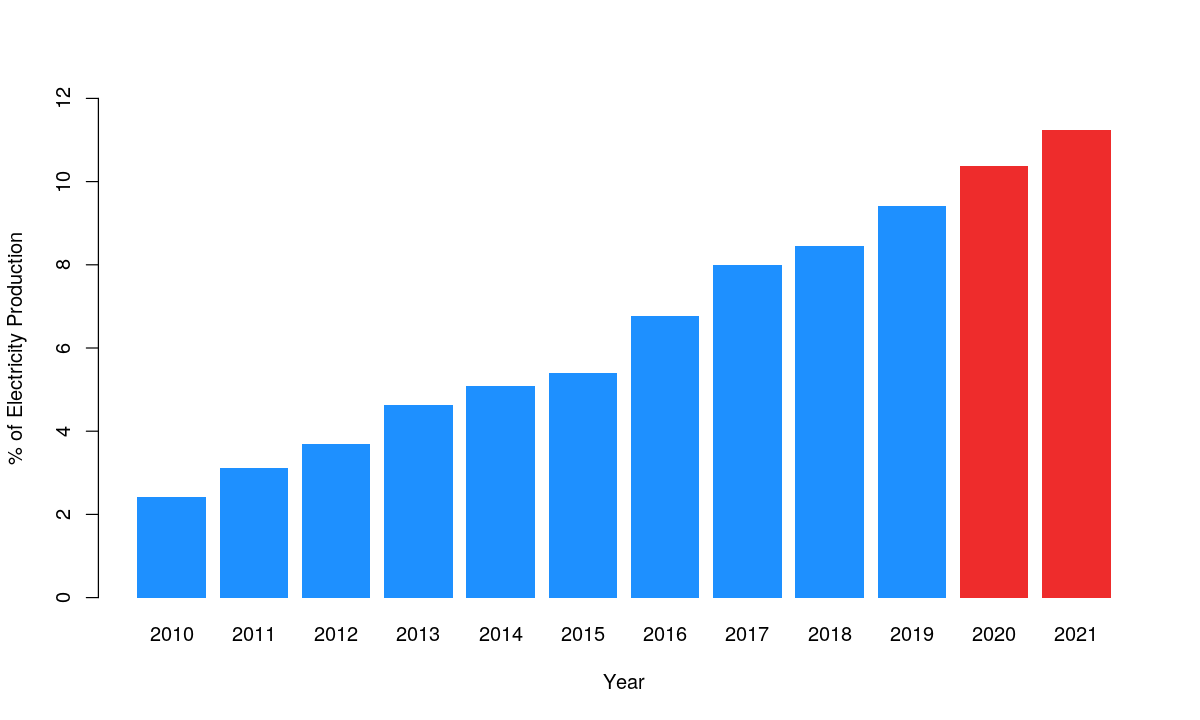

In [656]:
yr_avg <- rbind(yr_avg, c(2021, mean(renewables_2yr$mean[13:24])))

# Plot yearly average
cols <- ifelse(yr_avg$year > 2019, "firebrick2", "dodgerblue")
barplot(avg_pct ~ year, yr_avg, 
        xlab = "Year", ylab = "% of Electricity Production", ylim = c(0,12), col = cols, border = NA)

In [657]:
print(t(yr_avg))

               [,1]        [,2]        [,3]        [,4]        [,5]        [,6]
year    2010.000000 2011.000000 2012.000000 2013.000000 2014.000000 2015.000000
avg_pct    2.419215    3.104869    3.690491    4.618677    5.077554    5.408938
               [,7]        [,8]        [,9]      [,10]     [,11]      [,12]
year    2016.000000 2017.000000 2018.000000 2019.00000 2020.0000 2021.00000
avg_pct    6.772713    8.006802    8.463058    9.42274   10.3697   11.24833


<br>

<h4><u>5 Year Forecast</u></h4>

In [658]:
renewables_5yr <- rnw_ARIMA(x = rnw_prct, h = 60)

In [659]:
options(repr.plot.width = 10, repr.plot.height = 5)

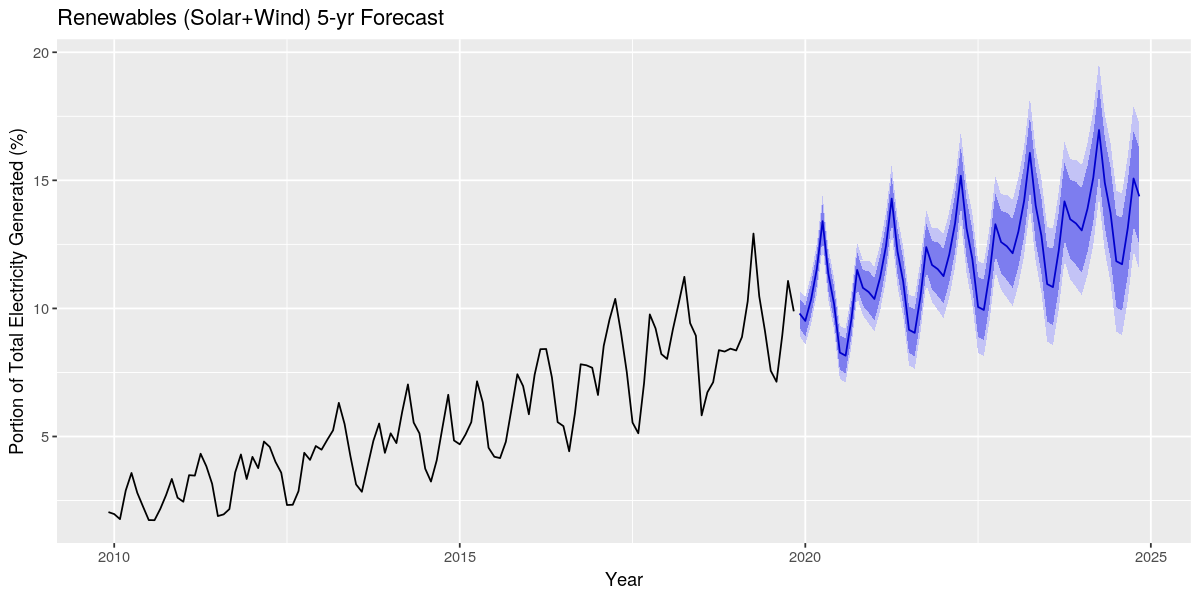

In [660]:
autoplot(renewables_5yr, include = 120) + ggtitle("Renewables (Solar+Wind) 5-yr Forecast") +
    xlab("Year") + ylab("Portion of Total Electricity Generated (%)")

In [661]:
options(repr.plot.width = 10, repr.plot.height = 6)

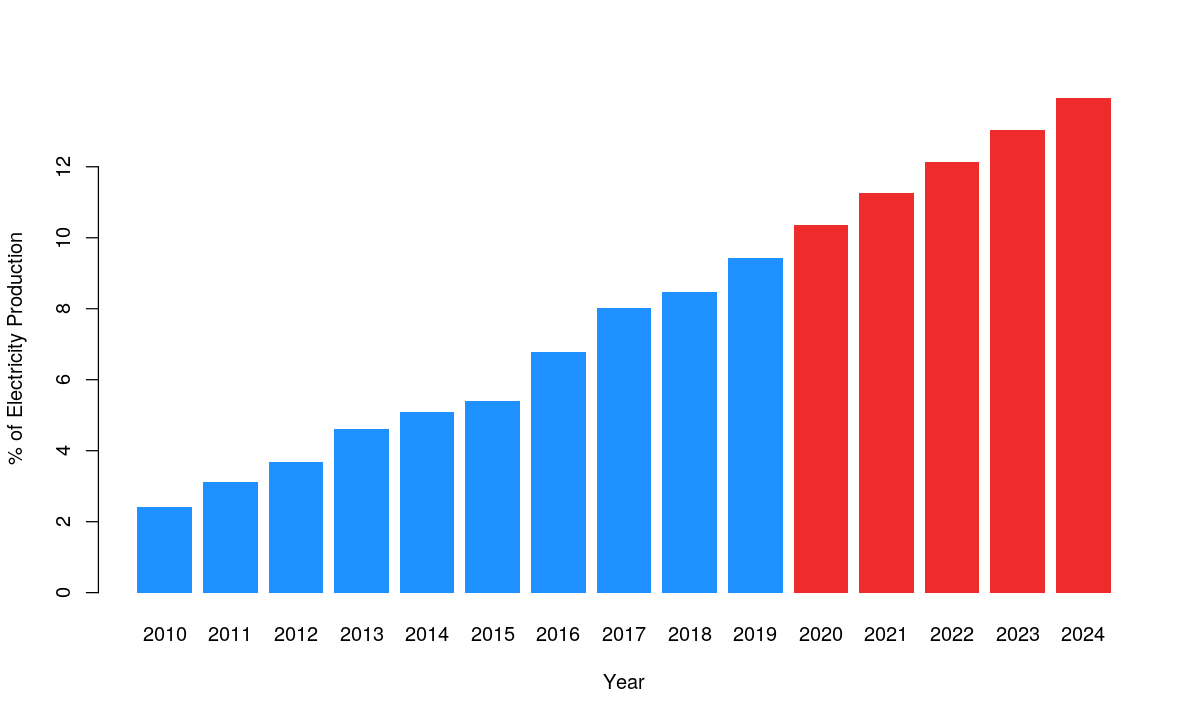

In [662]:
y3 <- c(2022, mean(renewables_5yr$mean[25:36]))
y4 <- c(2023, mean(renewables_5yr$mean[37:48]))
y5 <- c(2024, mean(renewables_5yr$mean[49:60]))

yr_avg <- rbind(yr_avg, y3)
yr_avg <- rbind(yr_avg, y4)
yr_avg <- rbind(yr_avg, y5)

# Plot yearly average
cols <- ifelse(yr_avg$year > 2019, "firebrick2", "dodgerblue")
barplot(avg_pct ~ year, yr_avg, 
        xlab = "Year", ylab = "% of Electricity Production", col = cols, border = NA)

In [663]:
print(t(yr_avg))

               [,1]        [,2]        [,3]        [,4]        [,5]        [,6]
year    2010.000000 2011.000000 2012.000000 2013.000000 2014.000000 2015.000000
avg_pct    2.419215    3.104869    3.690491    4.618677    5.077554    5.408938
               [,7]        [,8]        [,9]      [,10]     [,11]      [,12]
year    2016.000000 2017.000000 2018.000000 2019.00000 2020.0000 2021.00000
avg_pct    6.772713    8.006802    8.463058    9.42274   10.3697   11.24833
             [,13]      [,14]      [,15]
year    2022.00000 2023.00000 2024.00000
avg_pct   12.14097   13.03374   13.92651


<br>

---

<br>

<h3><b><u>Models - Multivariate</u></b></h3>

The second set includes additional terms from other data sets (see the EDA portion of this study) to improve the model. For this set, <b>regression with ARIMA errors</b> and <b>VAR</b> models are applied.

<h4><u>I - Regression with ARIMA errors</u></h4>

The same truncated data set of Solar + Wind generation as apercent of total electrical production will be used here as the response variable:

In [664]:
# Renewables = (Wind + Solar Electrical Production)
head(rnw_prct)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1999,,,,,,,,,,,,0.1850780
2000,0.2077245,0.2584613,0.1309368,0.1346704,0.1497312,,,,,,,


<br>

<b>Capacity as a Regressor</b>

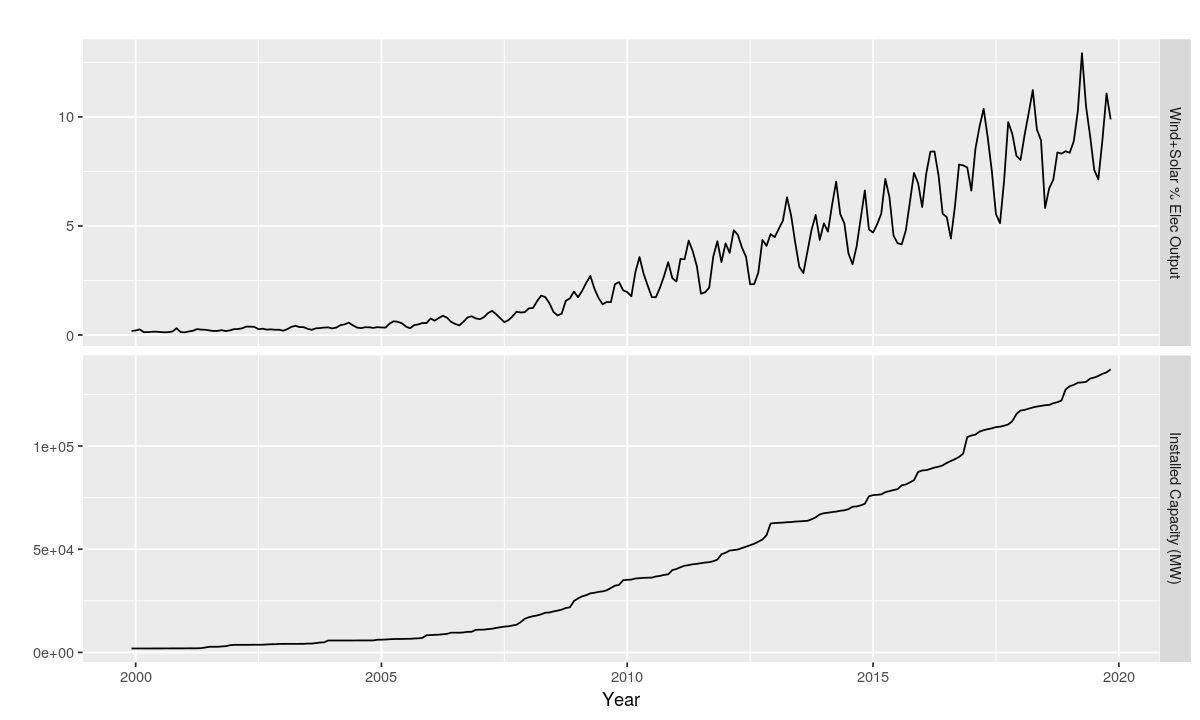

In [676]:
rnw_cap <- solar_cap_ts + wind_cap_ts
rnw_cap <- window(rnw_cap, start = c(1999, 12), end = c(2019,11))

autoplot(cbind("Wind+Solar % Elec Output" = rnw_prct, "Installed Capacity (MW)" = rnw_cap), facets = T) + 
    xlab("Year") + ylab("")

In [661]:
options(repr.plot.width = 8, repr.plot.height = 4)

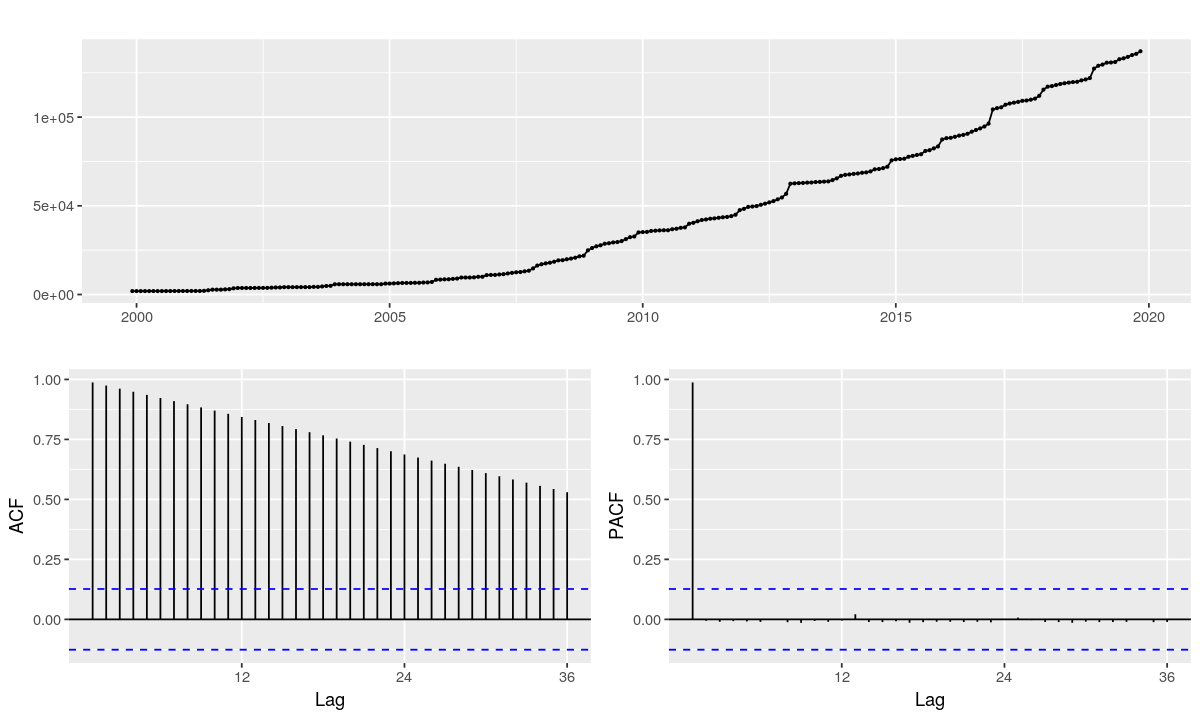

In [677]:
ggtsdisplay(rnw_cap)

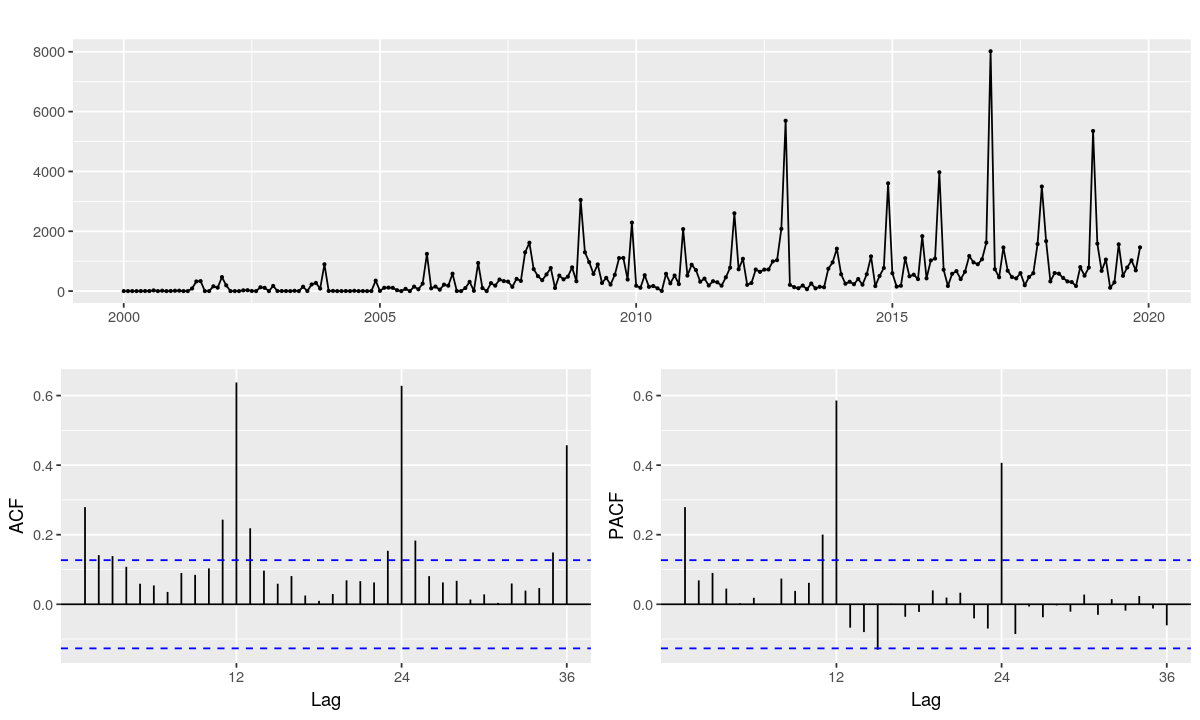

In [678]:
rnw_cap %>% diff(n = 1) %>% ggtsdisplay

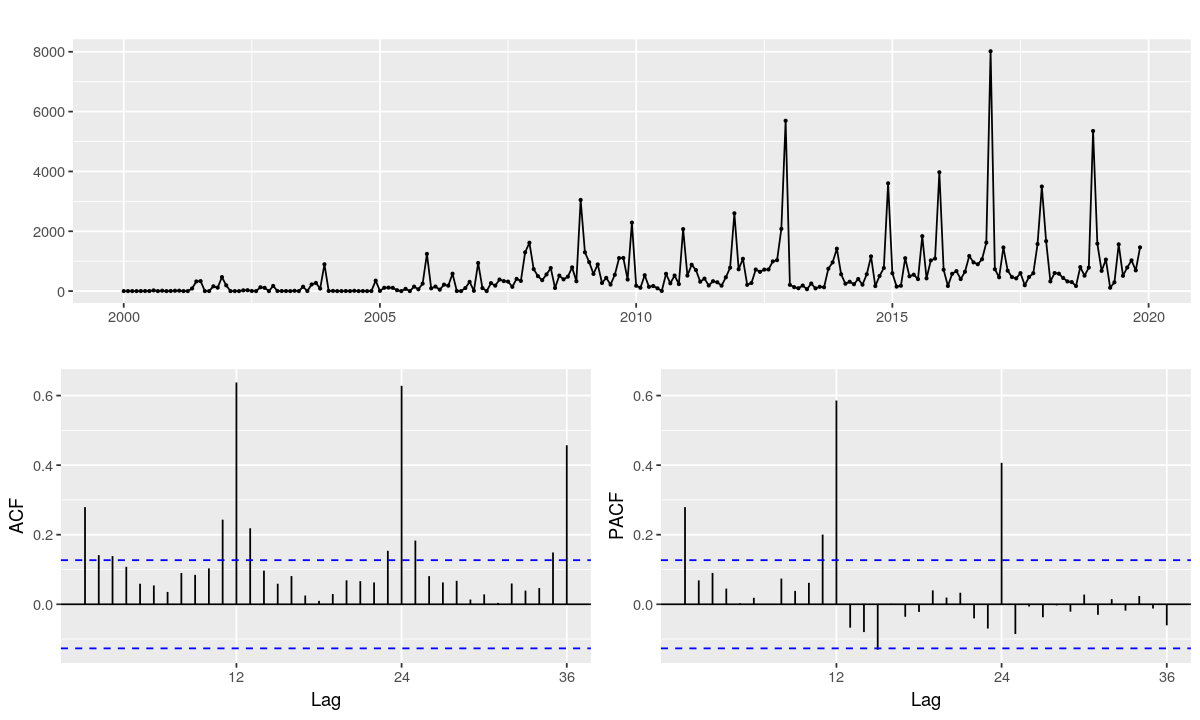

In [681]:
rnw_cap %>% diff(n = 12) %>% ggtsdisplay

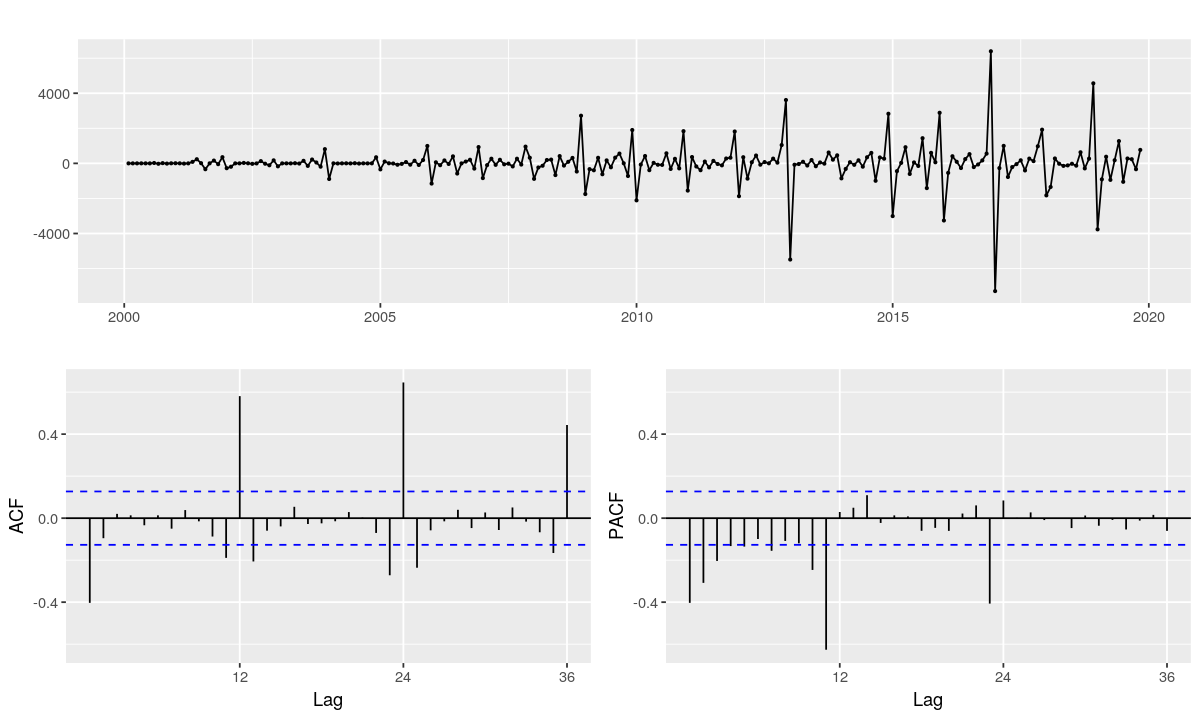

In [684]:
rnw_cap %>% diff(n = 12) %>% diff(n = 1) %>% ggtsdisplay

The initial analysis seems to indicate that 1 seasonal and 1 nonseasonal difference might work best for the capacity forecast.

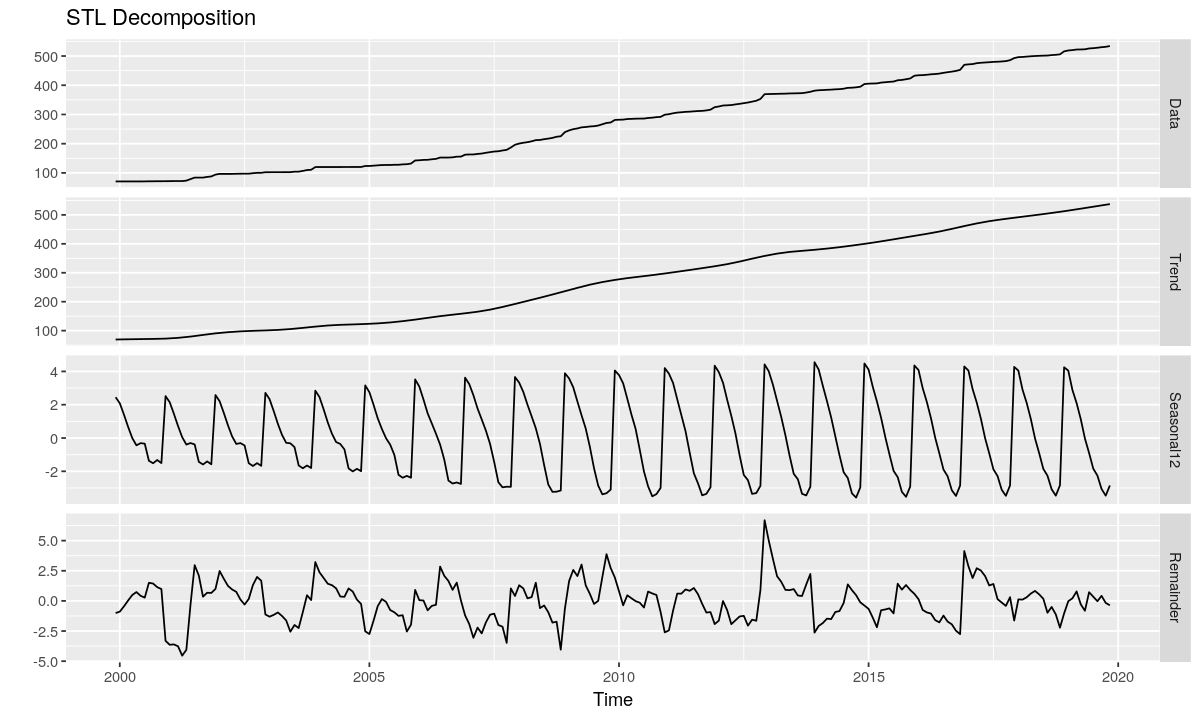

In [687]:
fit <- mstl(rnw_cap, lambda = 'auto')
autoplot(fit) + ggtitle("STL Decomposition")

<br>

Fit an ARIMA model with `arima.auto` to the capacity data:

In [692]:
cap_model <- auto.arima(rnw_cap, lambda = 'auto', stepwise = F)
summary(cap_model)

Series: rnw_cap 
ARIMA(1,1,1)(1,1,2)[12] 
Box Cox transformation: lambda= 0.4669239 

Coefficients:
         ar1      ma1     sar1     sma1     sma2
      0.8653  -0.6392  -0.7746  -0.1563  -0.4873
s.e.  0.0771   0.1198   0.1134   0.1318   0.1146

sigma^2 estimated as 2.707:  log likelihood=-439.66
AIC=891.32   AICc=891.71   BIC=911.87

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE       MASE
Training set 18.98233 477.6915 276.9445 0.1974348 1.086049 0.04040033
                   ACF1
Training set -0.0538559



	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)(1,1,2)[12]
Q* = 15.647, df = 19, p-value = 0.6807

Model df: 5.   Total lags used: 24



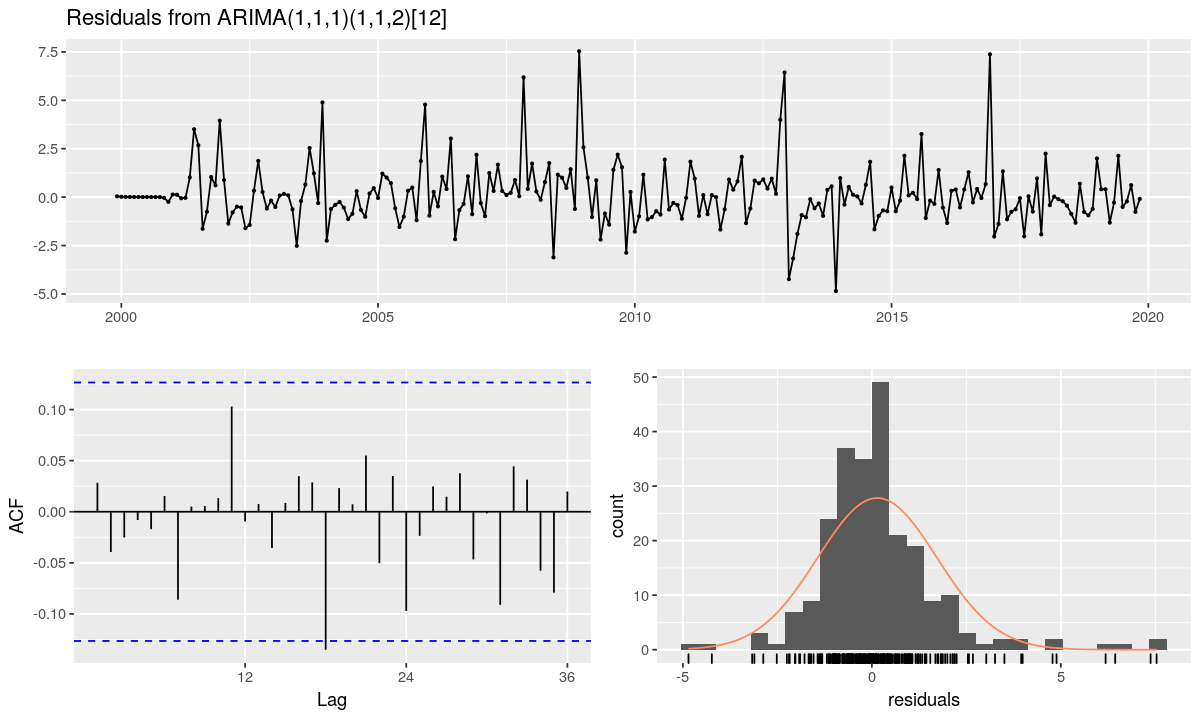

In [693]:
checkresiduals(cap_model)

The chosen $\text{ARIMA}(1,1,1)(1,1,2)_{12}$ model with $\lambda \approx 0.467$ has acceptable residuals that are very close to white noise. It is also in line with the information from the differencing and ACF/PACF examination. This model will be used to forecast the capacity variable for the regression model with ARIMA errors.

<br>

<b>Natural Gas Production as a Regressor</b>

The biggest competitor for Renewable energy is Natural Gas. Electricity from natural gas (also as a percent of total) is included as the second regression variable to see if it has an impact on the forecast of renewable output. Again, the time period of NG production is chosen to be consistent with renewable data.

<br>

In [697]:
tot <- monthly_dta_ts$Elec_by_Source[,"V14"]
ng_prod <- monthly_dta_ts$Elec_by_Source[,"V4"]
ng_pct <- ng_prod/tot*100
ng_pct <- window(ng_pct, start = c(1999, 12), end = c(2019,11))

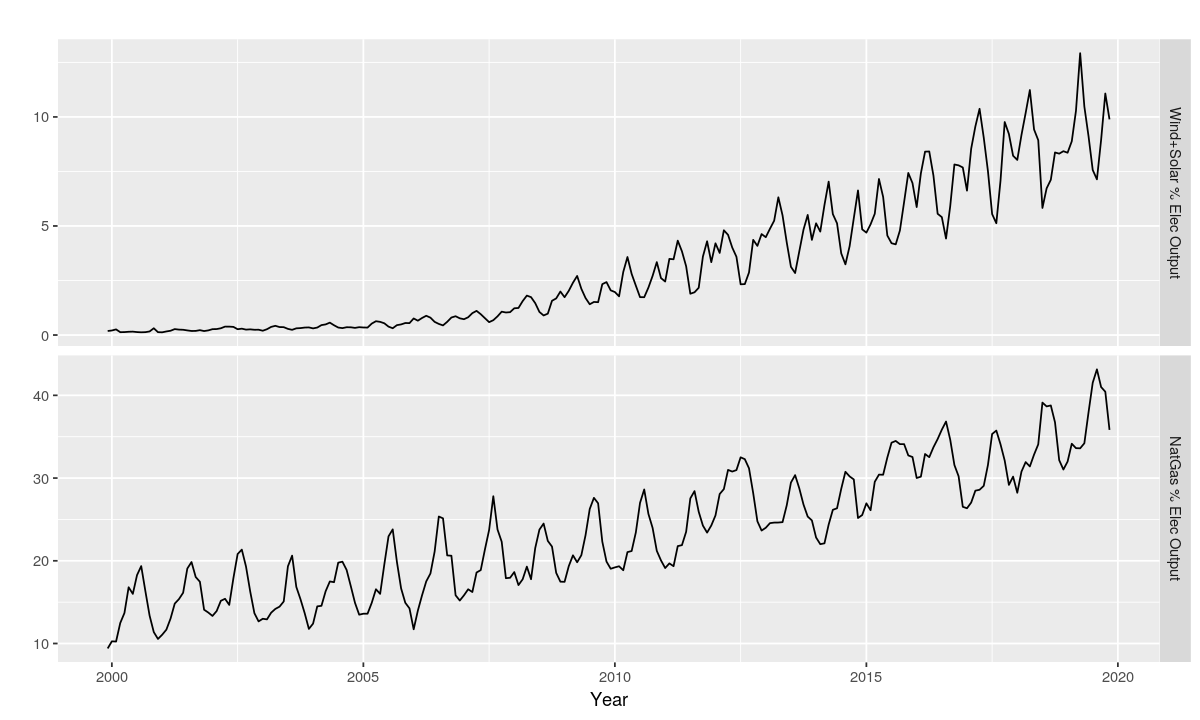

In [698]:
autoplot(cbind("Wind+Solar % Elec Output" = rnw_prct, "NatGas % Elec Output" = ng_pct), facets = T) + 
    xlab("Year") + ylab("")

In [699]:
options(repr.plot.width = 8, repr.plot.height = 4)

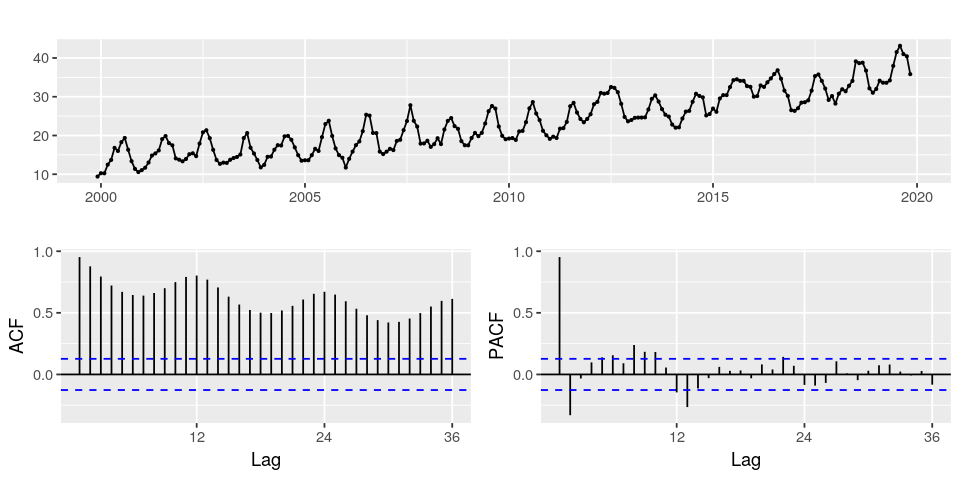

In [700]:
ggtsdisplay(ng_pct)

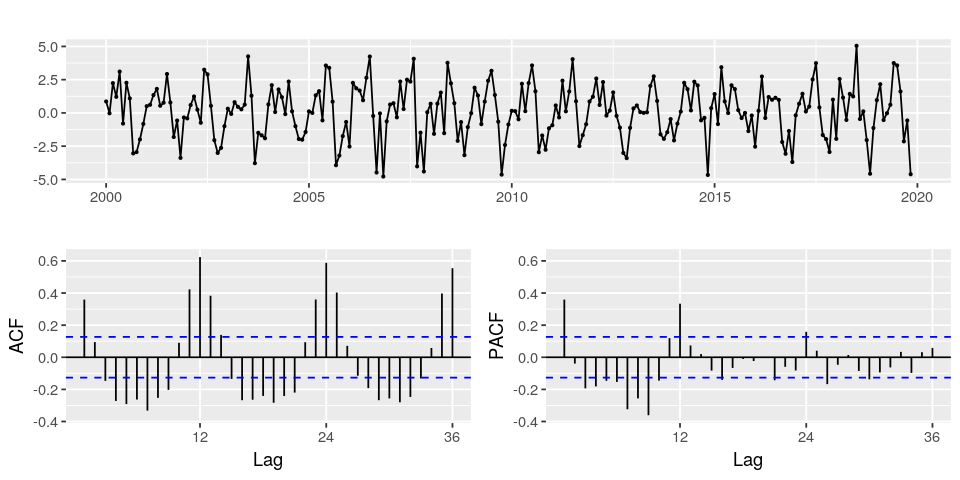

In [702]:
ng_pct %>% diff(n = 12) %>% ggtsdisplay

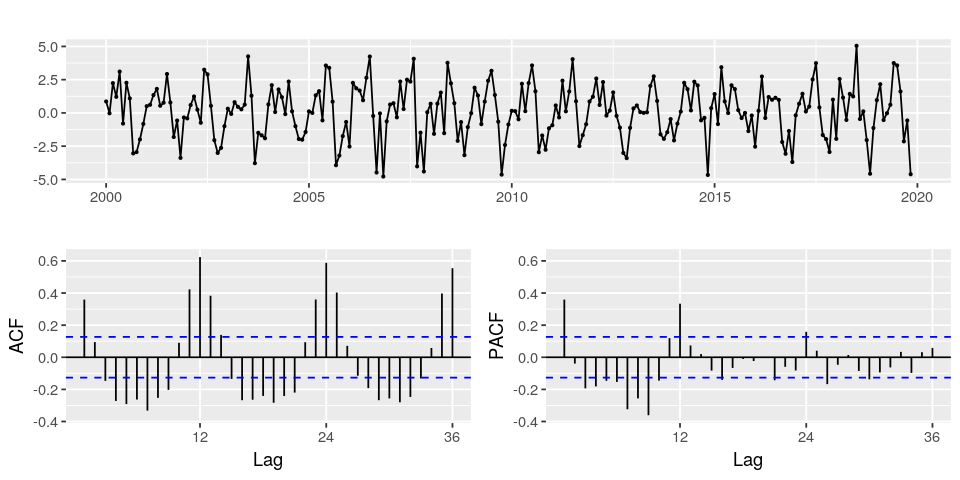

In [703]:
ng_pct %>% diff(n = 1) %>% ggtsdisplay

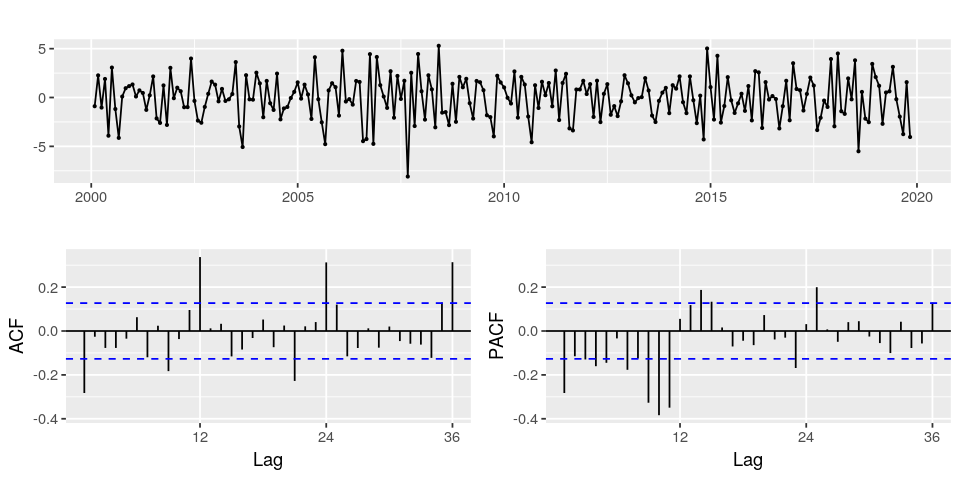

In [704]:
ng_pct %>% diff(n = 12) %>% diff(n = 1) %>% ggtsdisplay

The initial analysis seems to indicate that 1 seasonal and 1 nonseasonal difference might work best for the capacity forecast.

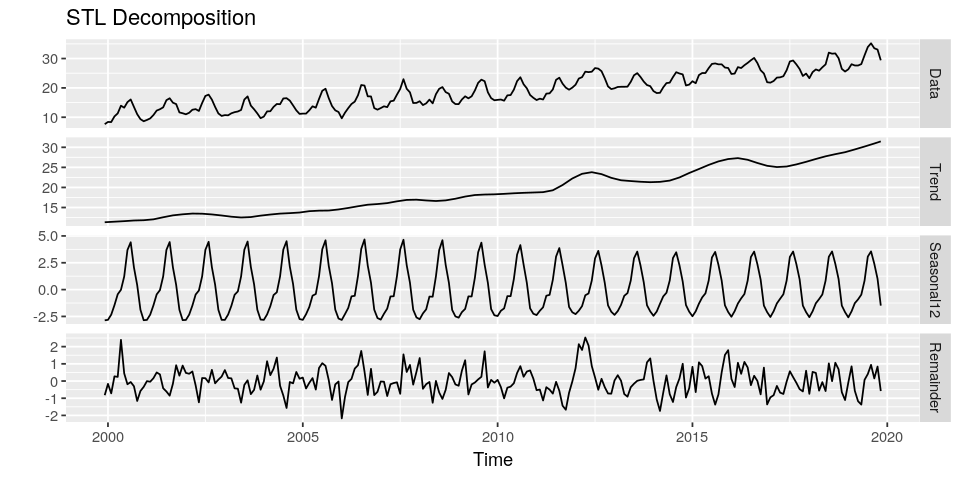

In [712]:
fit <- mstl(ng_pct, lambda = 'auto')
autoplot(fit) + ggtitle("STL Decomposition")

As suspected, the value of $\lambda \approx 0.94$ is very close to one, so a Box-Cox transformation will not be used here.

In [713]:
BoxCox.lambda(ng_pct)

[1] 0.9363653

<br>

Fit an ARIMA model with `arima.auto` to the capacity data:

In [709]:
ng_mdl <- auto.arima(ng_pct, lambda = NULL, stepwise = T)
summary(ng_mdl)

Series: ng_pct 
ARIMA(1,0,1)(2,1,0)[12] with drift 

Coefficients:
         ar1      ma1     sar1     sar2   drift
      0.8647  -0.1605  -0.6599  -0.3599  0.0977
s.e.  0.0420   0.0787   0.0633   0.0640  0.0213

sigma^2 estimated as 1.578:  log likelihood=-376.74
AIC=765.47   AICc=765.85   BIC=786.05

Training set error measures:
                        ME     RMSE       MAE        MPE     MAPE      MASE
Training set -0.0001845659 1.211068 0.9357135 -0.3837944 4.193449 0.4217921
                    ACF1
Training set 0.001917446



	Ljung-Box test

data:  Residuals from ARIMA(1,0,1)(2,1,0)[12] with drift
Q* = 28.122, df = 19, p-value = 0.08111

Model df: 5.   Total lags used: 24



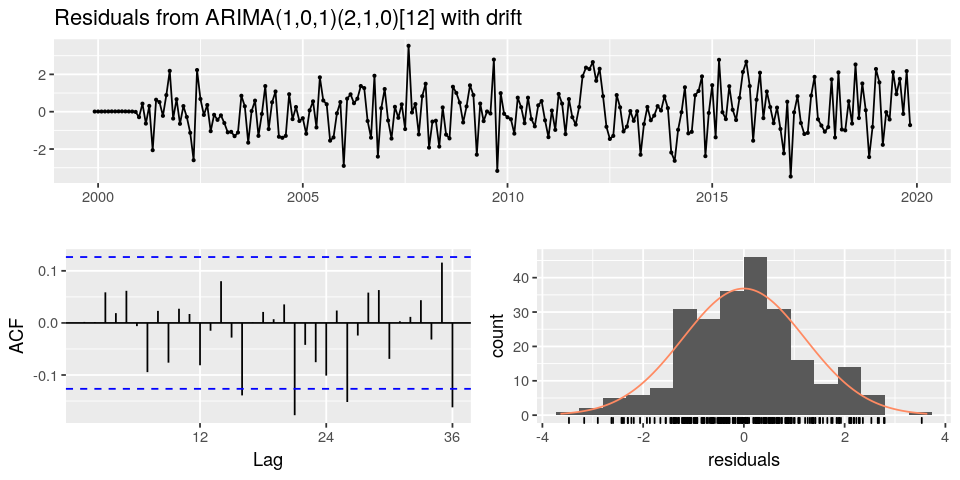

In [710]:
checkresiduals(ng_mdl)

The chosen $\text{ARIMA}(1,0,1)(2,1,0)_{12}$ model with drift has acceptable residuals close to white noise. More analysis can be performed but this model seems acceptable for our basic forecast.

<br>

<h4><u>Forecasting the covariates:</u></h4>

In [714]:
cap_fc1 <- forecast(cap_model, h = 12)
cap_fc2 <- forecast(cap_model, h = 24)
cap_fc5 <- forecast(cap_model, h = 60)

In [715]:
ng_fc1 <- forecast(ng_mdl, h = 12)
ng_fc2 <- forecast(ng_mdl, h = 24)
ng_fc5 <- forecast(ng_mdl, h = 60)

<br>

<h4><u>Building the model:</u></h4>

In [736]:
rnw_prod_ARerr <- auto.arima(rnw_prct, xreg = ng_pct, stepwise = F)
summary(rnw_prod_ARerr)

Series: rnw_prct 
Regression with ARIMA(1,0,1)(0,1,1)[12] errors 

Coefficients:
         ar1      ma1     sma1   drift     xreg
      0.9639  -0.6138  -0.3965  0.0466  -0.0434
s.e.  0.0255   0.0813   0.0612  0.0149   0.0204

sigma^2 estimated as 0.1992:  log likelihood=-138.45
AIC=288.9   AICc=289.28   BIC=309.48

Training set error measures:
                      ME      RMSE       MAE       MPE    MAPE      MASE
Training set 0.008358252 0.4302126 0.2947583 -9.349708 16.5292 0.5516037
                   ACF1
Training set 0.03895352


<br>

When using capacity, the model effectively had a coefficient of zero. It seems that natural gas production might have a negative impact on the output of renewables.


	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,0,1)(0,1,1)[12] errors
Q* = 48.871, df = 19, p-value = 0.0001918

Model df: 5.   Total lags used: 24



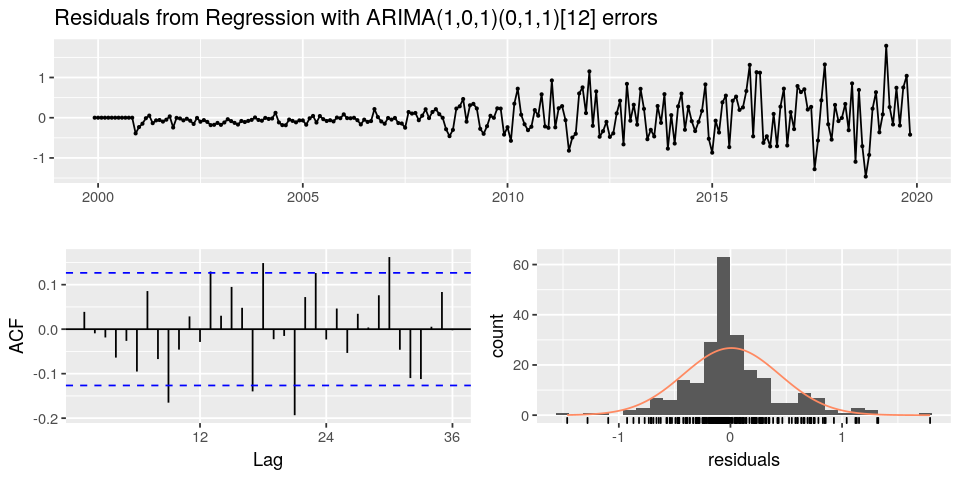

In [737]:
checkresiduals(rnw_prod_ARerr)

The residuals of the fitted model are cause for some concern. There is still much data that has not been captured, and no indication at this point that this model will perform better than the univariate model. It might still ne informative to attempt a forecast and see.

<br>

<h4><u>Forecast: Regression with ARIMA errors</u></h4>

In [740]:
rnw_reg_fc1 <- forecast(rnw_prod_ARerr, xreg = ng_fc1$mean)
rnw_reg_fc2 <- forecast(rnw_prod_ARerr, xreg = ng_fc2$mean)
rnw_reg_fc5 <- forecast(rnw_prod_ARerr, xreg = ng_fc5$mean)

<br>

<h4><b>VAR Model</b></h4>

In [760]:
rnw_VAR <- VAR(cbind(rnw_prct, rnw_cap, ng_pct), type = 'both', season = 12)
summary(rnw_VAR)


VAR Estimation Results:
Endogenous variables: rnw_prct, rnw_cap, ng_pct 
Deterministic variables: both 
Sample size: 239 
Log Likelihood: -2404.582 
Roots of the characteristic polynomial:
0.999 0.789 0.5012
Call:
VAR(y = cbind(rnw_prct, rnw_cap, ng_pct), type = "both", season = 12L)


Estimation results for equation rnw_prct: 
rnw_prct = rnw_prct.l1 + rnw_cap.l1 + ng_pct.l1 + const + trend + sd1 + sd2 + sd3 + sd4 + sd5 + sd6 + sd7 + sd8 + sd9 + sd10 + sd11 

              Estimate Std. Error t value Pr(>|t|)    
rnw_prct.l1  5.050e-01  5.792e-02   8.718 6.58e-16 ***
rnw_cap.l1   3.441e-05  5.314e-06   6.476 5.92e-10 ***
ng_pct.l1    2.030e-02  2.025e-02   1.003  0.31712    
const       -2.729e-01  2.879e-01  -0.948  0.34415    
trend       -8.814e-04  2.068e-03  -0.426  0.67034    
sd1         -3.297e-01  1.855e-01  -1.777  0.07687 .  
sd2         -3.021e-01  1.925e-01  -1.569  0.11806    
sd3          3.717e-02  1.953e-01   0.190  0.84921    
sd4          3.502e-01  1.881e-01   1.86

In [761]:
rnw_fc_VAR1 <- forecast(rnw_VAR, h = 12)
rnw_fc_VAR2 <- forecast(rnw_VAR, h = 24)
rnw_fc_VAR5 <- forecast(rnw_VAR, h = 60)

<br>

In [745]:
options(repr.plot.width = 12, repr.plot.height = 6)

Warning message:
“Ignoring unknown parameters: PI”Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


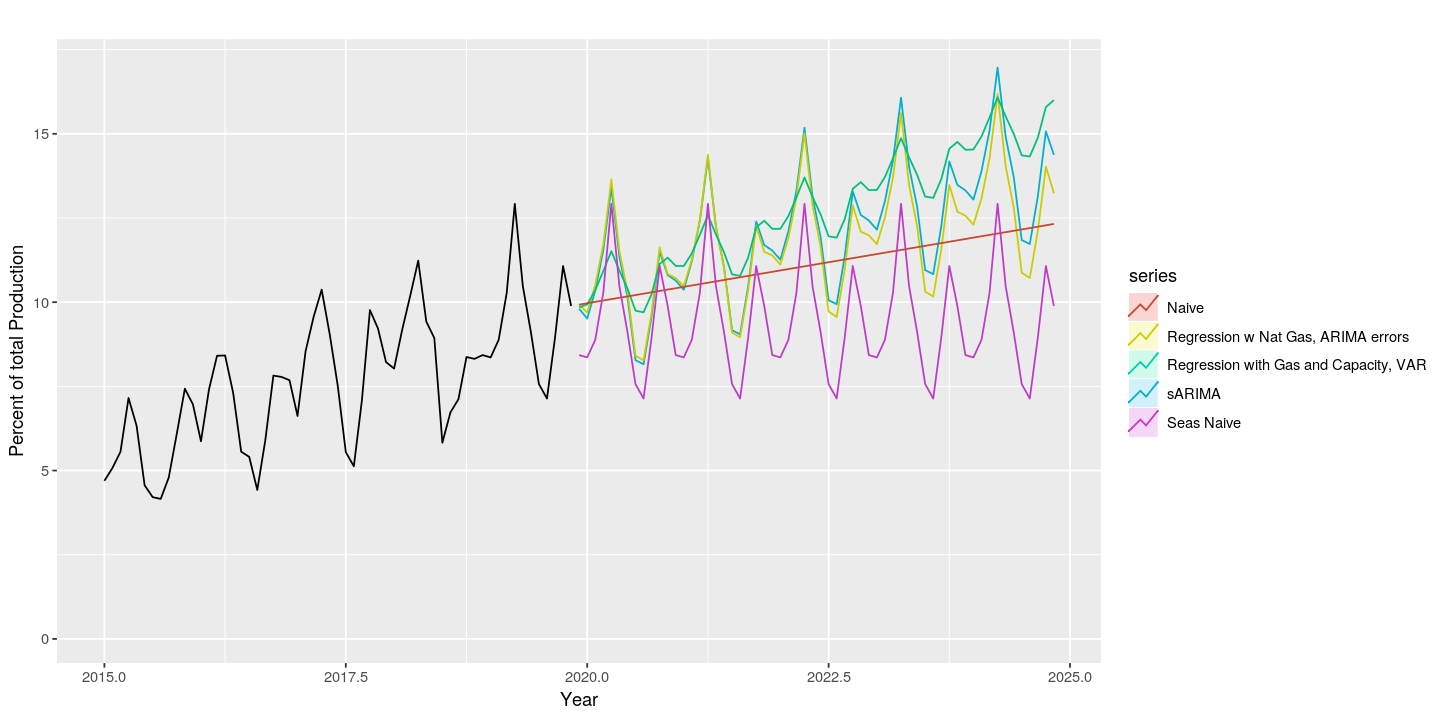

In [773]:
autoplot(rnw_prct) + 
    autolayer(renewables_5yr, series = "sARIMA", PI = F) + 
    autolayer(rnw_reg_fc5, series = "Regression w Nat Gas, ARIMA errors", PI = F) +
    autolayer(rnw_fc_VAR5$forecast$rnw_prct$mean, series = "Regression with Gas and Capacity, VAR", PI = F) +
    autolayer(rwf(rnw_prct, h = 60, drift = T), series = "Naive", PI = F) +
    autolayer(snaive(rnw_prct, h = 60, drift = T), series = "Seas Naive", PI = F) +
    xlim(c(2015, NA)) + xlab("Year") + ylab("Percent of total Production")

In [769]:
VARselect(rnw_prct, type = 'both')

,1,2,3,4,5,6,7,8,9,10
AIC(n),-0.5344357,-0.6426424,-0.6362899,-0.7929212,-0.8182211,-0.8191809,-0.8267378,-0.8260919,-0.9491794,-1.3756330
HQ(n),-0.5163463,-0.6185232,-0.6061410,-0.7567425,-0.7760125,-0.7709426,-0.7724697,-0.7657939,-0.8828518,-1.3032755
SC(n),-0.4895912,-0.5828497,-0.5615491,-0.7032322,-0.7135839,-0.6995956,-0.6922043,-0.6766101,-0.7847496,-1.1962550
FPE(n),0.5860008,0.5259028,0.5292560,0.4525263,0.4412241,0.4408049,0.4374916,0.4377808,0.3870868,0.2527036
